### Define file path

In [13]:
# 파일 경로 설정
import pandas as pd
import os

# PC filepath 설정
BASE_FILEPATH = "/home/songmu/"
# BASE_FILEPATH = "/home/widen/"

# 사용할 client 및 server filepath 설정(연, 월, 일, 시)
CLIENT_FILEPATH = BASE_FILEPATH + "Multipath/cpp/results/client/1/"
SERVER_FILEPATH = BASE_FILEPATH + "Multipath/cpp/results/server/exp_1007/1/"

# 패킷 수신시 패킷 정보 logging 해둔 filepath
KT_LOG_FILEPATH = SERVER_FILEPATH + "logs/kt_log.csv"
LG_LOG_FILEPATH = SERVER_FILEPATH + "logs/lg_log.csv"
# 위 KT, LG 를 이용하여 만들어줄 Combine traffic의 저장 경로
COMBINE_LOG_FILEPATH = SERVER_FILEPATH + "logs/combine_log.csv"

# 송신측의 패킷 정보 logging 해둔 filepath
SENDING_LOG_FILEPATH = CLIENT_FILEPATH + "logs/packet_log.csv"
 
# 수신측에서 raw packet 저장한 filepath 
KT_BINS_FILEPATH = SERVER_FILEPATH + "bins/kt"
LG_BINS_FILEPATH = SERVER_FILEPATH + "bins/lg"
# 위 bins file과 Combine traffic logging을 이용하여 새로운 bin file을 저장해줄 filepath
COMBINE_BINS_FILEPATH = SERVER_FILEPATH + "bins/combine"
os.makedirs(COMBINE_BINS_FILEPATH, exist_ok = True)

# 생성한 그래프들 저장할 filepath
GRAPH_PATH = SERVER_FILEPATH + "graphs"
os.makedirs(GRAPH_PATH, exist_ok = True)

# 생성할 frames 저장할 filepath
FRAMES_FILEPATH = SERVER_FILEPATH + "frames"

In [ ]:
# # SSIM 

# import os
# import glob
# import cv2
# import numpy as np
# import pandas as pd
# from skimage.metrics import structural_similarity as ssim
# import matplotlib.pyplot as plt


# # delay 목록 설정
# delay = 50
# label = "kt"
# sequence_num = 1539

# # SSIM 계산
# def cal_ssim(img1, img2):
#     ssim_value = ssim(img1, img2, channel_axis=-1)
#     return ssim_value

# def get_file_path_by_sequence(folder_path, sequence_number):
#     pattern = os.path.join(folder_path, f"{sequence_number}_*.png")
#     matching_files = glob.glob(pattern)
    
#     # 매칭된 파일이 있다면 첫 번째 파일 경로를 반환
#     if matching_files:
#         return matching_files[0]
#     else:
#         return None  # 해당 sequence_number로 시작하는 파일이 없을 경우


# CLIENT_FILEPATH = BASE_FILEPATH + "Multipath/cpp/results/client/1/"
# FRAMES_FILEPATH = BASE_FILEPATH + "Multipath/cpp/results/server/exp_1007/1/frames"

# image_og_folder = f"{CLIENT_FILEPATH}frames_with_sequence"
# image_compare_folder = f"{FRAMES_FILEPATH}/{label}_delay_{delay}"

# image_og_path = get_file_path_by_sequence(image_og_folder, sequence_num)
# image_compare_path = get_file_path_by_sequence(image_compare_folder, sequence_num)

# print(image_og_path)
# print(image_compare_path)

# image_og = cv2.imread(image_og_path)
# image_compare = cv2.imread(image_compare_path)

# ssim = cal_ssim(image_og, image_compare)
# print(ssim)

/home/songmu/Multipath/cpp/results/client/1/frames_with_sequence/1539_1728278114977138.png
/home/songmu/Multipath/cpp/results/server/exp_1007/1/frames/kt_delay_50/1539_1728278115002527_1728278115037793_1728278114977138.png
0.27677976945404703


### Make combine_log.csv
## CSV file header 불러오는 것 들 통일해야 함 - 형식(스네이크)

In [11]:
import pandas as pd

# Read csv files
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col = None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col = None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col = None)

# 두 개의 DataFrame을 sequence_number 기준으로 병합 (outer join, 양쪽 모두에 존재하는 행을 포함)
merged_df = pd.merge(kt_log_df, lg_log_df, on="sequence_number", how="outer", suffixes=('_kt', '_lg'))

# 빈 리스트 생성
combined_data = []

# 같은 sequence_number에서 latency가 적은 row를 선택하고, 마지막 column에 kt 또는 lg 추가
for index, row in merged_df.iterrows():
    if pd.isna(row['network_latency_ms_kt']):  # KT 데이터가 없을 경우 LG 데이터를 사용하고 'lg'를 추가
        combined_data.append([row['source ip_lg'], row['sequence_number'], row['timestamp_frame_lg'], row['timestamp_sending_lg'], row['received_time_lg'], row['network_latency_ms_lg'], row['message_size_lg'], 'lg'])
    elif pd.isna(row['network_latency_ms_lg']):  # LG 데이터가 없을 경우 KT 데이터를 사용하고 'kt'를 추가
        combined_data.append([row['source ip_kt'], row['sequence_number'], row['timestamp_frame_kt'], row['timestamp_sending_kt'], row['received_time_kt'], row['network_latency_ms_kt'], row['message_size_lg'], 'kt'])
    else:
        # 두 row 중 latency가 더 작은 것을 선택하고 그에 맞는 label 추가
        if row['network_latency_ms_kt'] < row['network_latency_ms_lg']:
            combined_data.append([row['source ip_kt'], row['sequence_number'], row['timestamp_frame_kt'], row['timestamp_sending_kt'], row['received_time_kt'], row['network_latency_ms_kt'], row['message_size_kt'], 'kt'])
        else:
            combined_data.append([row['source ip_lg'], row['sequence_number'], row['timestamp_frame_lg'], row['timestamp_sending_lg'], row['received_time_lg'], row['network_latency_ms_lg'], row['message_size_kt'], 'lg'])

# 결과를 DataFrame으로 변환
combined_log_df = pd.DataFrame(combined_data, columns= ["source_ip", "sequence_number", "timestamp_frame", "timestamp_sending", "received_time", "network_latency_ms", "message_size", "source"])
combined_log_df.to_csv(COMBINE_LOG_FILEPATH, index=False, header=True)

print(f"결과 파일이 {COMBINE_LOG_FILEPATH}에 저장되었습니다.")

결과 파일이 /home/songmu/Multipath/cpp/results/server/exp_1007/1/logs/combine_log.csv에 저장되었습니다.


  Latency Threshold (ms)  Packets covered by KT only  \
0                     33                          61   
1                     50                         627   
2                     60                         533   
3                     65                         336   
4                     70                         201   
5                     80                         118   
6                     90                         108   
7                    100                         103   
8               Infinite                          92   

   Packets covered by LG only  Packets where both alive  \
0                         173                        68   
1                         225                       383   
2                         183                      1027   
3                         126                      1373   
4                          78                      1582   
5                          34                      1722   
6                         

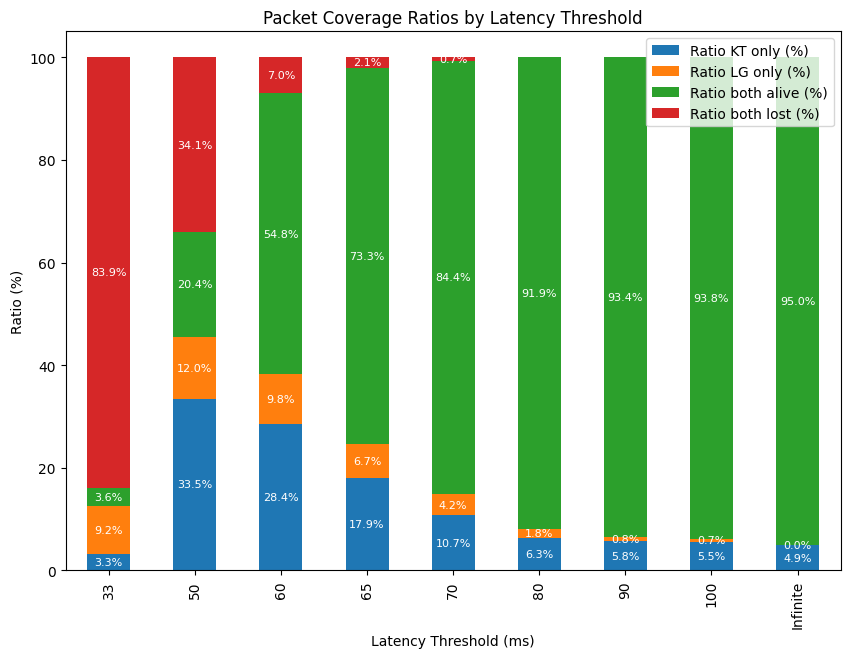

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)

# 'Sequence_number' 컬럼명을 'sequence number'로 변경하여 병합 시 일치시킴
# sending_log_df.rename(columns={'Sequence_number': 'sequence number'}, inplace=True)

# kt_log_df와 lg_log_df의 컬럼명에 접미사 추가 (단, 'sequence number'는 제외)
kt_log_df.rename(columns=lambda x: x + '_kt' if x != 'sequence_number' else x, inplace=True)
lg_log_df.rename(columns=lambda x: x + '_lg' if x != 'sequence_number' else x, inplace=True)

# sending_log_df를 기준으로 데이터 병합
merged_df = pd.merge(sending_log_df, kt_log_df, on="sequence_number", how="left")
merged_df = pd.merge(merged_df, lg_log_df, on="sequence_number", how="left")

# latency 임계값 리스트
thresholds = [33, 50, 60, 65, 70, 80, 90, 100, float('inf')]

# 결과를 저장할 리스트
results = []

for threshold in thresholds:
    # 각 경우에 대한 카운트 초기화
    count_kt_only = 0
    count_lg_only = 0
    count_both_alive = 0
    count_both_lost = 0

    # 각 행에 대해 패킷의 상태를 판단
    for index, row in merged_df.iterrows():
        # KT와 LG의 latency 값 가져오기
        kt_latency = row.get('network_latency_ms_kt')
        lg_latency = row.get('network_latency_ms_lg')

        # 패킷의 존재 여부 판단
        alive_kt = pd.notna(kt_latency) and kt_latency <= threshold
        alive_lg = pd.notna(lg_latency) and lg_latency <= threshold

        # 각 경우에 따라 카운트 증가
        if alive_kt and not alive_lg:
            count_kt_only += 1
        elif alive_lg and not alive_kt:
            count_lg_only += 1
        elif alive_kt and alive_lg:
            count_both_alive += 1
        else:
            count_both_lost += 1

    # 총 패킷 수 계산
    total_packets = count_kt_only + count_lg_only + count_both_alive + count_both_lost

    # 'both lost'를 제외한 총 패킷 수
    total_excl_both_lost = total_packets - count_both_lost

    # 'both lost'와 'both alive'를 제외한 총 패킷 수
    total_excl_both_lost_and_both_alive = total_packets - count_both_lost - count_both_alive

    # 각 경우에 대한 비율 계산 (퍼센트 형태)
    ratio_kt_only = (count_kt_only / total_packets * 100) if total_packets > 0 else 0
    ratio_lg_only = (count_lg_only / total_packets * 100) if total_packets > 0 else 0
    ratio_both_alive = (count_both_alive / total_packets * 100) if total_packets > 0 else 0
    ratio_both_lost = (count_both_lost / total_packets * 100) if total_packets > 0 else 0

    # 'both lost'를 제외한 비율 계산
    ratio_kt_only_excl_both_lost = (count_kt_only / total_excl_both_lost * 100) if total_excl_both_lost > 0 else 0
    ratio_lg_only_excl_both_lost = (count_lg_only / total_excl_both_lost * 100) if total_excl_both_lost > 0 else 0
    ratio_both_alive_excl_both_lost = (count_both_alive / total_excl_both_lost * 100) if total_excl_both_lost > 0 else 0

    # 'both lost'와 'both alive'를 제외한 비율 계산
    ratio_kt_only_excl_both_lost_and_both_alive = (count_kt_only / total_excl_both_lost_and_both_alive * 100) if total_excl_both_lost_and_both_alive > 0 else 0
    ratio_lg_only_excl_both_lost_and_both_alive = (count_lg_only / total_excl_both_lost_and_both_alive * 100) if total_excl_both_lost_and_both_alive > 0 else 0

    # 결과 저장
    results.append({
        'Latency Threshold (ms)': threshold if threshold != float('inf') else 'Infinite',
        'Packets covered by KT only': count_kt_only,
        'Packets covered by LG only': count_lg_only,
        'Packets where both alive': count_both_alive,
        'Packets where both lost': count_both_lost,
        'Total Packets': total_packets,
        'Ratio KT only (%)': f"{ratio_kt_only:.2f}%",
        'Ratio LG only (%)': f"{ratio_lg_only:.2f}%",
        'Ratio both alive (%)': f"{ratio_both_alive:.2f}%",
        'Ratio both lost (%)': f"{ratio_both_lost:.2f}%",
        'Ratio KT only (excluding both lost) (%)': f"{ratio_kt_only_excl_both_lost:.2f}%",
        'Ratio LG only (excluding both lost) (%)': f"{ratio_lg_only_excl_both_lost:.2f}%",
        'Ratio both alive (excluding both lost) (%)': f"{ratio_both_alive_excl_both_lost:.2f}%",
        'Ratio KT only (excluding both lost and both alive) (%)': f"{ratio_kt_only_excl_both_lost_and_both_alive:.2f}%",
        'Ratio LG only (excluding both lost and both alive) (%)': f"{ratio_lg_only_excl_both_lost_and_both_alive:.2f}%"
    })

# 결과를 데이터프레임으로 변환 후 출력
results_df = pd.DataFrame(results)
print(results_df)

# 그래프 그리기
threshold_labels = [str(t) if t != float('inf') else 'Infinite' for t in thresholds]

# 비율 데이터만 선택
ratio_columns = ['Ratio KT only (%)', 'Ratio LG only (%)', 'Ratio both alive (%)', 'Ratio both lost (%)']
ratio_df = results_df[ratio_columns].copy()
ratio_df.index = threshold_labels

# 비율 값을 숫자로 변환
for col in ratio_columns:
    ratio_df[col] = ratio_df[col].str.rstrip('%').astype(float)

# 스택형 막대 그래프 생성
ax = ratio_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# 각 바에 레이블 추가
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', color='white', fontsize=8)

plt.xlabel('Latency Threshold (ms)')
plt.ylabel('Ratio (%)')
plt.title('Packet Coverage Ratios by Latency Threshold')
plt.legend(loc='best')
plt.savefig(f'{GRAPH_PATH}/Packet_coverage_ratio.png')
plt.show()


  Latency Threshold (ms)  Packets covered by KT only  \
0                     33                          61   
1                     50                         627   
2                    100                         103   
3               Infinite                          92   

   Packets covered by LG only  Packets where both alive  \
0                         173                        68   
1                         225                       383   
2                          13                      1758   
3                           1                      1781   

   Packets where both lost  Total Packets Ratio both lost (%)  \
0                     1572           1874              83.88%   
1                      639           1874              34.10%   
2                        0           1874               0.00%   
3                        0           1874               0.00%   

  Ratio not both lost (%)  
0                  16.12%  
1                  65.90%  
2            

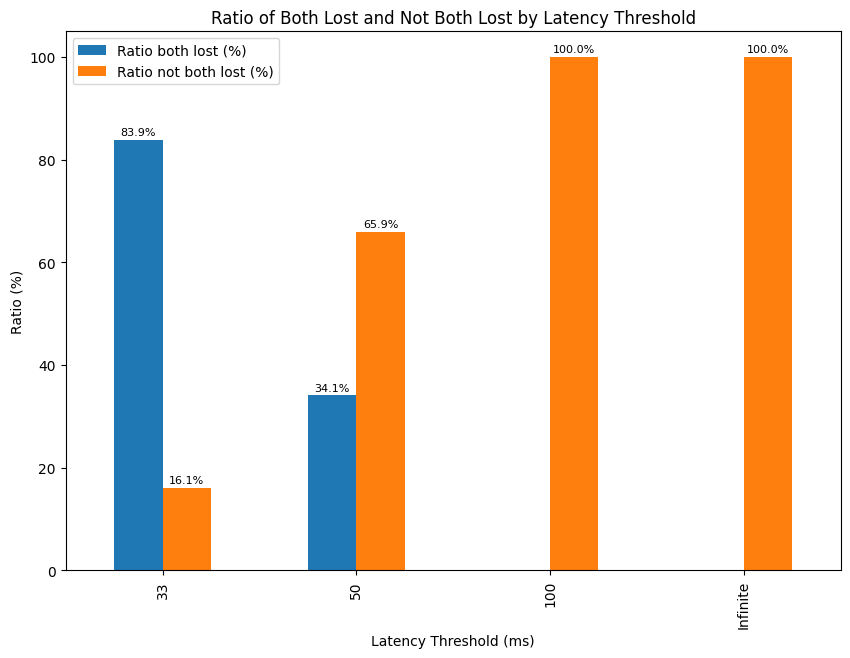

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)

# 'Sequence_number' 컬럼명을 'sequence number'로 변경하여 병합 시 일치시킴
sending_log_df.rename(columns={'Sequence_number': 'sequence number'}, inplace=True)

# kt_log_df와 lg_log_df의 컬럼명에 접미사 추가 (단, 'sequence number'는 제외)
kt_log_df.rename(columns=lambda x: x + '_kt' if x != 'sequence number' else x, inplace=True)
lg_log_df.rename(columns=lambda x: x + '_lg' if x != 'sequence number' else x, inplace=True)

# sending_log_df를 기준으로 데이터 병합
merged_df = pd.merge(sending_log_df, kt_log_df, on="sequence number", how="left")
merged_df = pd.merge(merged_df, lg_log_df, on="sequence number", how="left")

# latency 임계값 리스트
thresholds = [33, 50, 60, 70, 80, 90, 100, float('inf')]

# 결과를 저장할 리스트
results = []

for threshold in thresholds:
    # 각 경우에 대한 카운트 초기화
    count_kt_only = 0
    count_lg_only = 0
    count_both_alive = 0
    count_both_lost = 0

    # 각 행에 대해 패킷의 상태를 판단
    for index, row in merged_df.iterrows():
        # KT와 LG의 latency 값 가져오기
        kt_latency = row.get('network_latency_ms_kt')
        lg_latency = row.get('network_latency_ms_lg')

        # 패킷의 존재 여부 판단
        alive_kt = pd.notna(kt_latency) and kt_latency <= threshold
        alive_lg = pd.notna(lg_latency) and lg_latency <= threshold

        # 각 경우에 따라 카운트 증가
        if alive_kt and not alive_lg:
            count_kt_only += 1
        elif alive_lg and not alive_kt:
            count_lg_only += 1
        elif alive_kt and alive_lg:
            count_both_alive += 1
        else:
            count_both_lost += 1

    # 총 패킷 수 계산
    total_packets = count_kt_only + count_lg_only + count_both_alive + count_both_lost

    # 'both lost'를 제외한 총 패킷 수
    total_not_both_lost = total_packets - count_both_lost

    # 각 경우에 대한 비율 계산 (퍼센트 형태)
    ratio_kt_only = (count_kt_only / total_packets * 100) if total_packets > 0 else 0
    ratio_lg_only = (count_lg_only / total_packets * 100) if total_packets > 0 else 0
    ratio_both_alive = (count_both_alive / total_packets * 100) if total_packets > 0 else 0
    ratio_both_lost = (count_both_lost / total_packets * 100) if total_packets > 0 else 0

    # 'Both lost'를 제외한 나머지 비율 계산
    ratio_not_both_lost = 100 - ratio_both_lost

    # 결과 저장
    results.append({
        'Latency Threshold (ms)': threshold if threshold != float('inf') else 'Infinite',
        'Packets covered by KT only': count_kt_only,
        'Packets covered by LG only': count_lg_only,
        'Packets where both alive': count_both_alive,
        'Packets where both lost': count_both_lost,
        'Total Packets': total_packets,
        'Ratio both lost (%)': f"{ratio_both_lost:.2f}%",
        'Ratio not both lost (%)': f"{ratio_not_both_lost:.2f}%"
    })

# 결과를 데이터프레임으로 변환 후 출력
results_df = pd.DataFrame(results)
print(results_df)

# 그래프 그리기
threshold_labels = [str(t) if t != float('inf') else 'Infinite' for t in thresholds]

# 비율 데이터만 선택
ratio_columns = ['Ratio both lost (%)', 'Ratio not both lost (%)']
ratio_df = results_df[ratio_columns].copy()
ratio_df.index = threshold_labels

# 비율 값을 숫자로 변환
for col in ratio_columns:
    ratio_df[col] = ratio_df[col].str.rstrip('%').astype(float)

# 막대 그래프 생성
ax = ratio_df.plot(kind='bar', stacked=False, figsize=(10, 7))

# 각 바에 레이블 추가
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.xlabel('Latency Threshold (ms)')
plt.ylabel('Ratio (%)')
plt.title('Ratio of Both Lost and Not Both Lost by Latency Threshold')
plt.legend(loc='best')
plt.show()


### Make combine_bin files

In [109]:
# Make combine bins

import os
import shutil

for index, row in combined_log_df.iterrows():
    sequence_number = row['sequence number']
    source = row['source']
    
    # 복사할 파일 경로 설정
    if source == 'kt':
        source_folder = KT_BINS_FILEPATH
    elif source == 'lg':
        source_folder = LG_BINS_FILEPATH
    else:
        print(f"Unknown source: {source} at index {index}")
        continue
    
    # 파일명 찾기
    file_name = f"{sequence_number}_*.bins"
    source_file_path = os.path.join(source_folder, file_name)
    
    # 실제 파일명을 찾아 복사
    matching_files = [f for f in os.listdir(source_folder) if f.startswith(f"{sequence_number}_")]
    if not matching_files:
        print(f"No matching file found for sequence_number {sequence_number} in {source_folder}")
        continue
    
    # 첫 번째 매칭된 파일을 복사
    file_to_copy = matching_files[0]
    shutil.copy(os.path.join(source_folder, file_to_copy), os.path.join(COMBINE_BINS_FILEPATH, file_to_copy))
    
    # print(f"Copied {file_to_copy} to {combine_bins_folder}")
print('Copy completed')

Copy completed


### Generate frame (run c++ code)

In [110]:
# 현재는 오로지 network latency만 고려
# post_processing/config.h 에서 filepath 수정 필요

!bash run.sh

-- Configuring done
-- Generating done
-- Build files have been written to: /home/songmu/Multipath/cpp/post_processing/build
Scanning dependencies of target MakeFramesProcessing
[ 50%] Building CXX object CMakeFiles/MakeFramesProcessing.dir/make_frames_with_decoding_latency.cpp.o
[100%] Linking CXX executable MakeFramesProcessing
[100%] Built target MakeFramesProcessing
Stream [kt] processing start
[kt | delay_33] 프레임 seq_num: 0이(가) 사용되었습니다.
[kt | delay_33] 프레임 seq_num: 1이(가) 사용되었습니다.
[kt | delay_33] 프레임 seq_num: 2이(가) 사용되었습니다.
[kt | delay_33] 프레임 seq_num: 3이(가) 사용되었습니다.
[kt | delay_33] 프레임 seq_num: 4이(가) 사용되었습니다.
[kt | delay_33] 프레임 seq_num: 5이(가) 사용되었습니다.
[kt] 프레임 6이(가) 조건 불만족으로 스킵되었습니다.
[kt | delay_33] 프레임 seq_num: 7이(가) 사용되었습니다.
[kt] 프레임 8이(가) 조건 불만족으로 스킵되었습니다.
[kt | delay_33] 프레임 seq_num: 9이(가) 사용되었습니다.
[kt] 프레임 10이(가) 조건 불만족으로 스킵되었습니다.
[kt] 프레임 11이(가) 조건 불만족으로 스킵되었습니다.
[kt] 프레임 12이(가) 조건 불만족으로 스킵되었습니다.
[kt] 프레임 13이(가) 조건 불만족으로 스킵되었습니다.
[kt] 프레임 14이(가) 조건 불만족으로 스킵되었습니다.
[kt] 프레임 1

### Measure Packet Reception Ratio

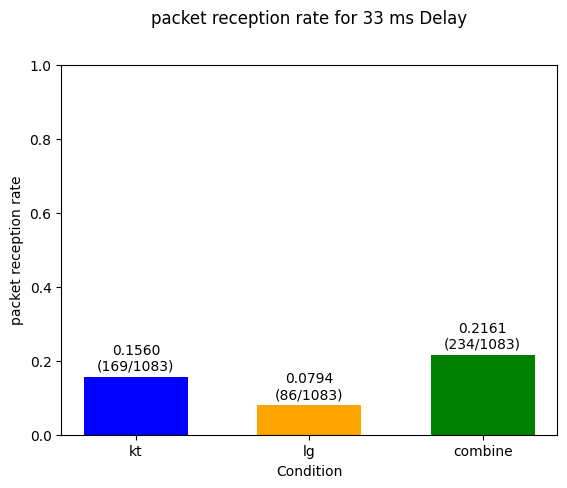

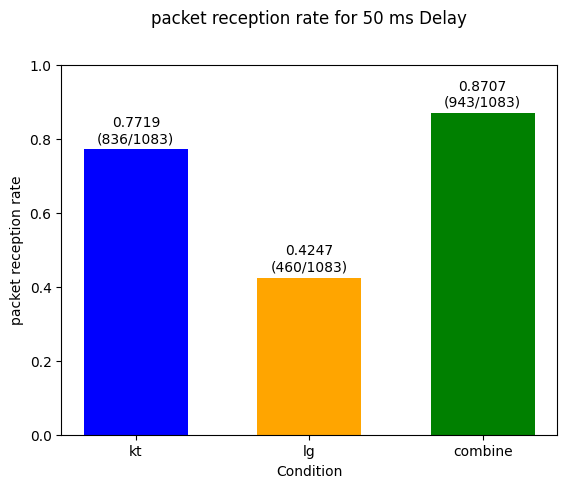

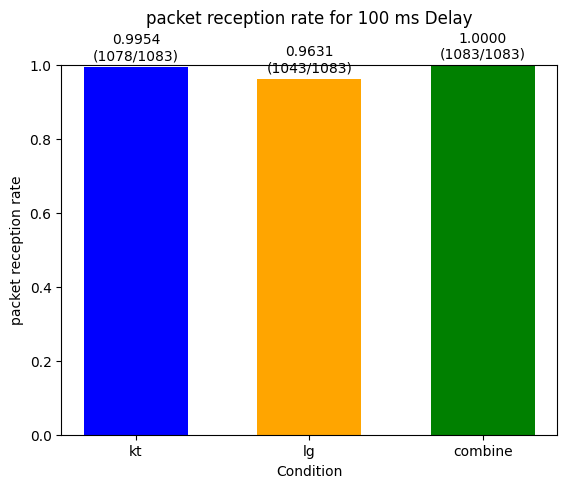

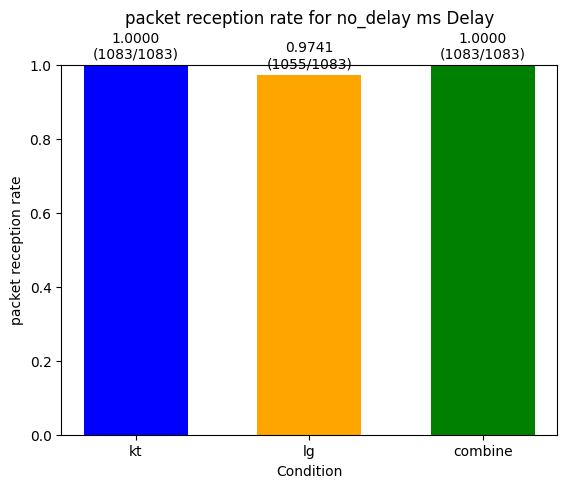

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def calculate_loss_rate(log_df, total_sequence, delay_col):
    num_received = log_df[delay_col].sum()
    packet_reception_rate = num_received / total_sequence
    return packet_reception_rate, num_received


def plot_loss_rates_by_delay(kt_log_df, lg_log_df, combine_log_df, total_sequence, delays):
    log_dfs = [kt_log_df, lg_log_df, combine_log_df]
    labels = ['kt', 'lg', 'combine']
    
    for delay in delays:
        packet_reception_rates = []
        num_received_list = []
        
        for log_df in log_dfs:
            col = f'is_use_{delay}'
            packet_reception_rate, num_received = calculate_loss_rate(log_df, total_sequence, col)
            packet_reception_rates.append(packet_reception_rate)
            num_received_list.append(num_received)
        
        # Plotting for the current delay
        x = np.arange(len(labels))
        width = 0.6  # width of the bars
        
        fig, ax = plt.subplots()
        ax.bar(x, packet_reception_rates, width, color=['blue', 'orange', 'green'])
        
        # Annotating the bars with the percentage and the actual fraction
        for i, (packet_reception_rate, num_received) in enumerate(zip(packet_reception_rates, num_received_list)):
            ax.text(i, packet_reception_rate + 0.01, 
                    f'{(packet_reception_rate):.4f}\n({num_received}/{total_sequence})',
                    ha='center', va='bottom', fontsize=10)
        
        # Labeling and formatting the plot
        ax.set_xlabel('Condition')
        ax.set_ylabel('packet reception rate')
        ax.set_title(f'packet reception rate for {delay} ms Delay', pad = 30)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 1)  # Set y-axis limit to 100% loss rate
        
        plt.savefig(f'{GRAPH_PATH}/prr_{delay}.png')
        plt.show()

combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col = None)
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col = None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col = None)


total_sequence = sending_log_df.shape[0]    # 보낸 전체 메시지 수
delays = [33, 50, 100, 'no_delay']
plot_loss_rates_by_delay(kt_log_df, lg_log_df, combined_log_df, total_sequence, delays)

## Plot loss

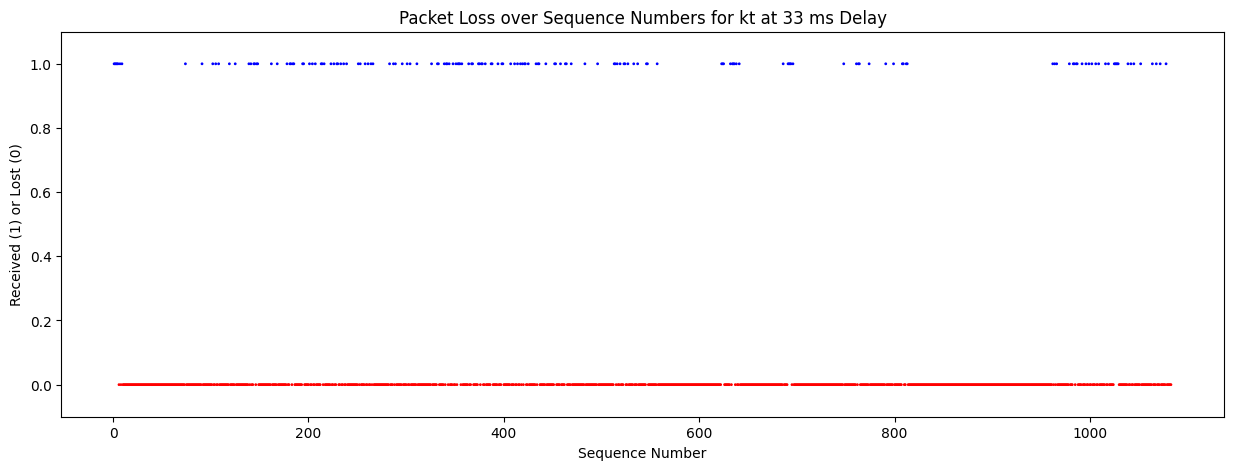

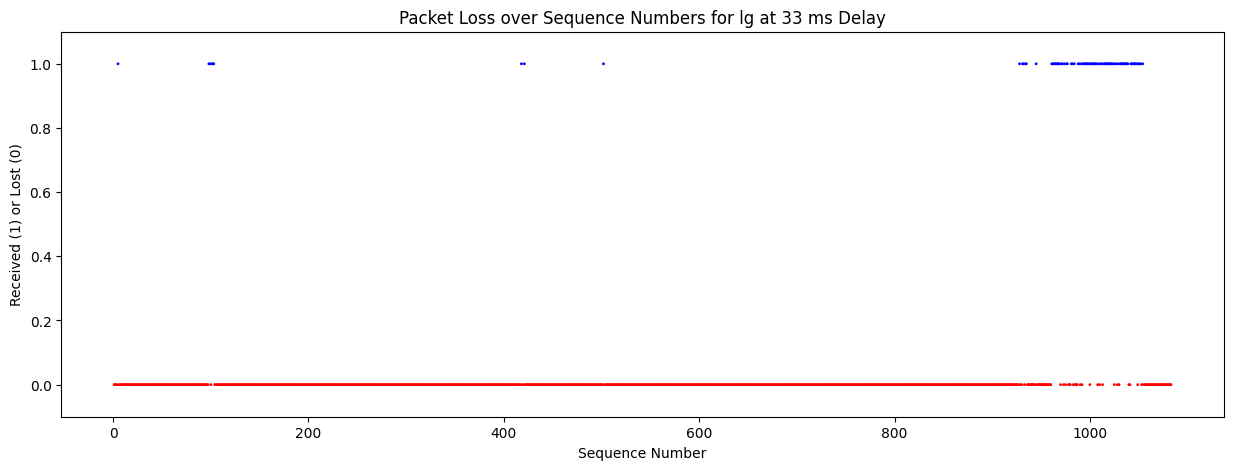

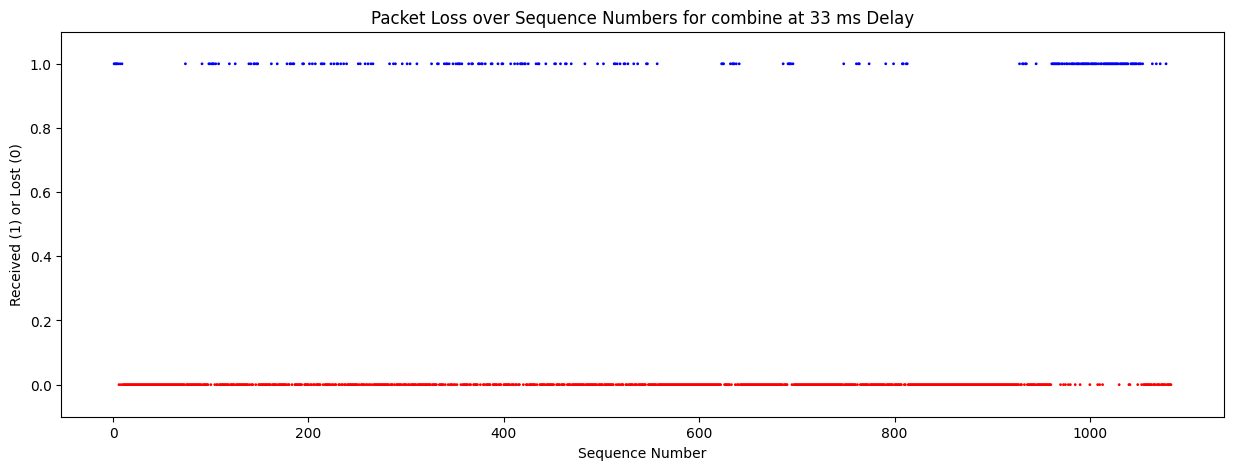

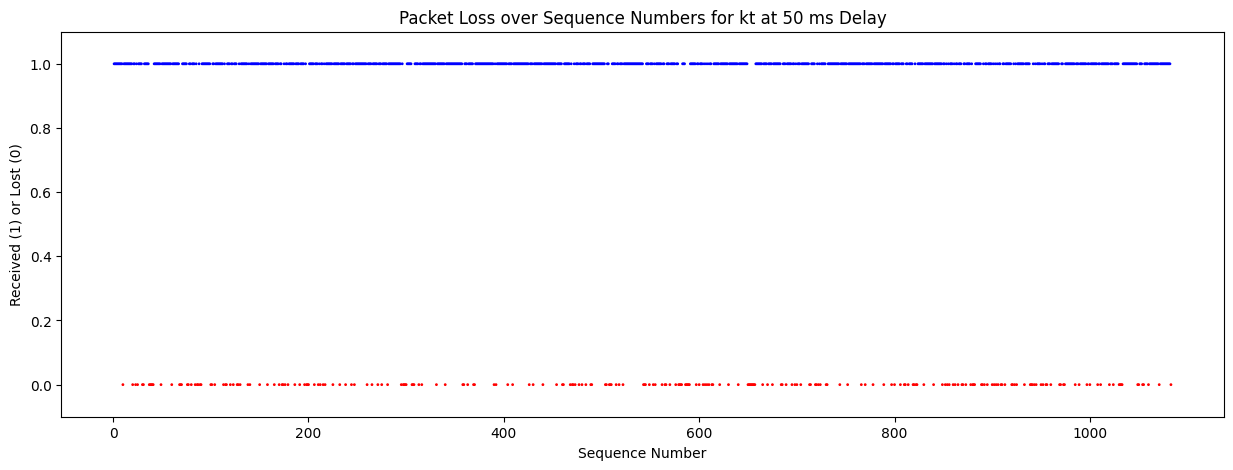

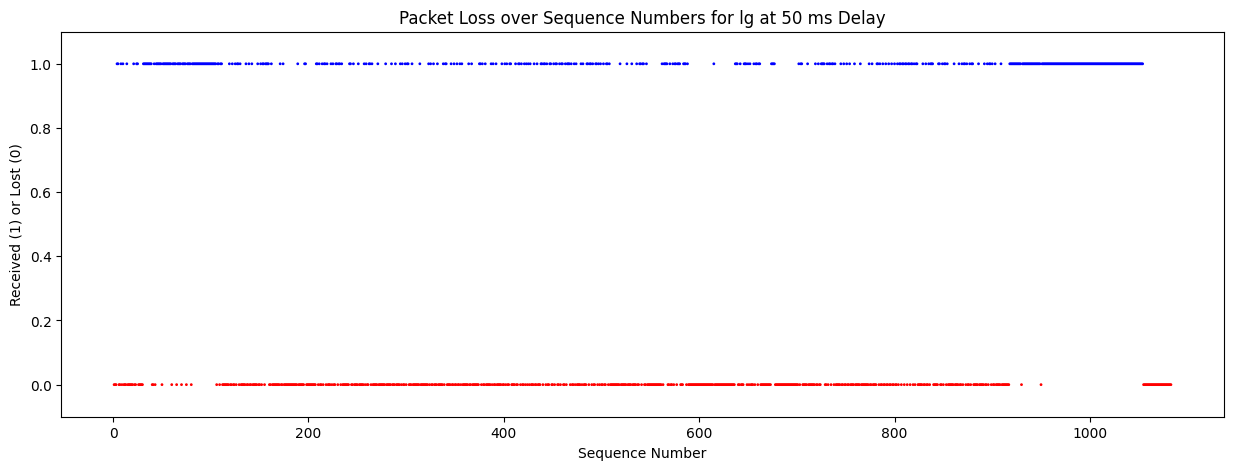

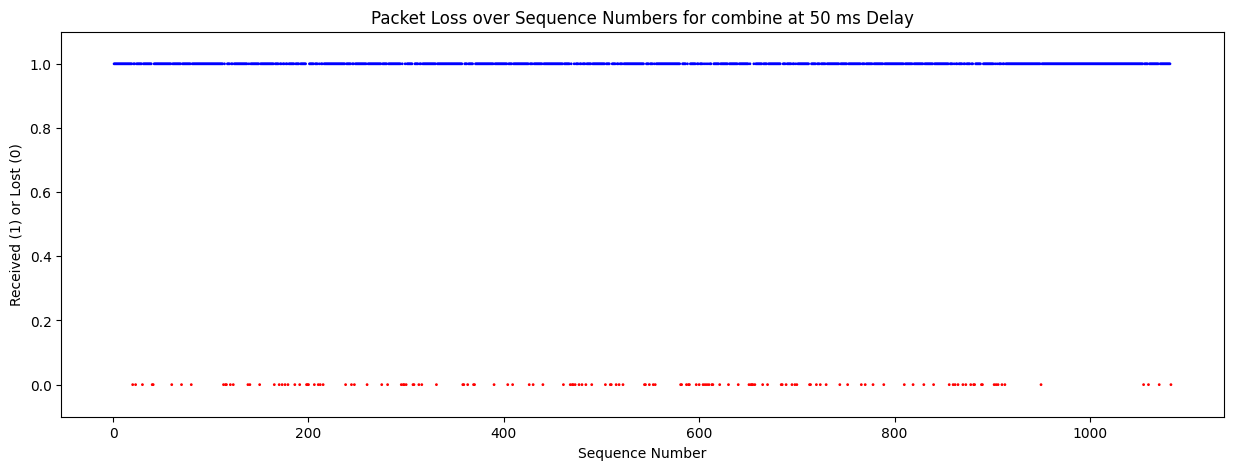

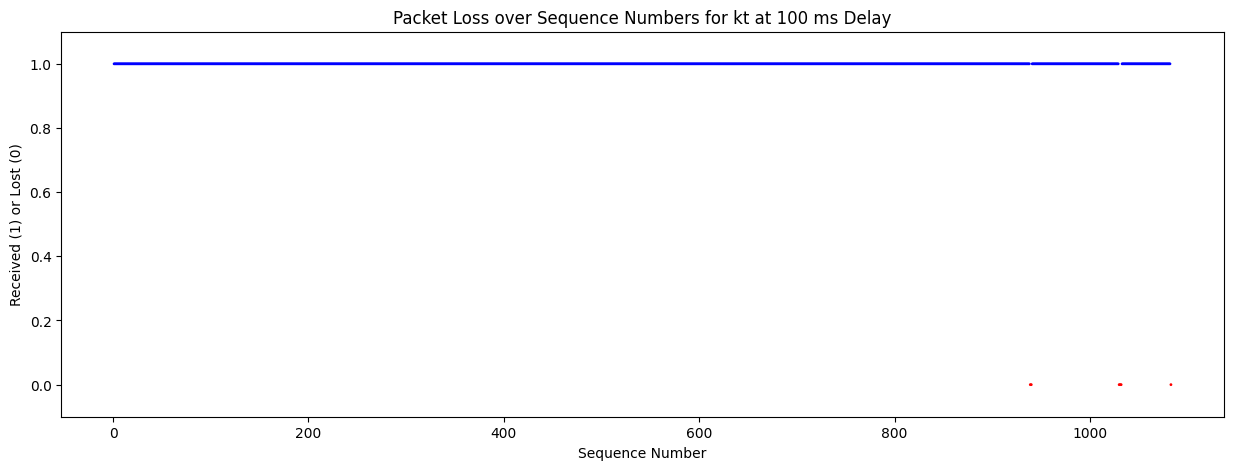

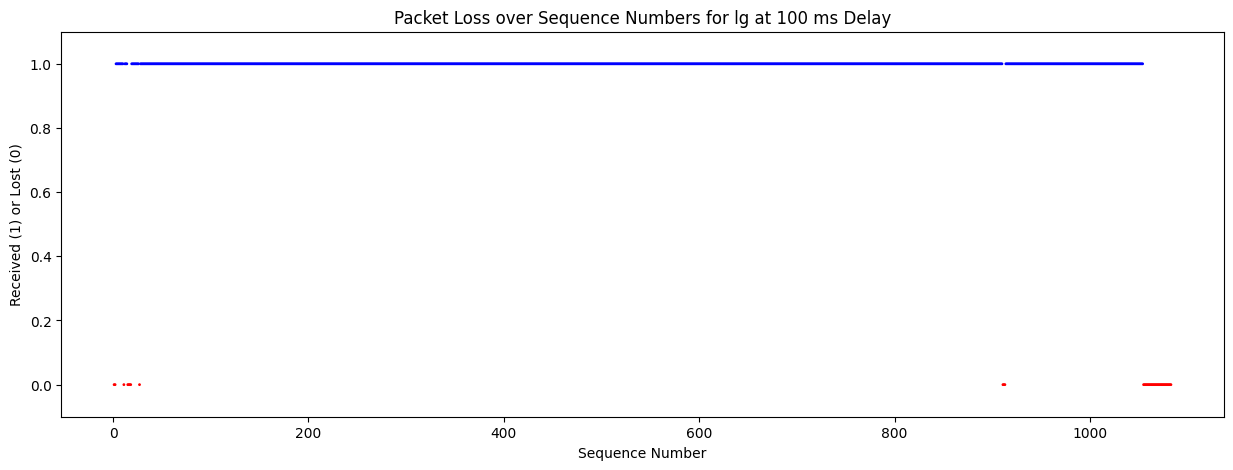

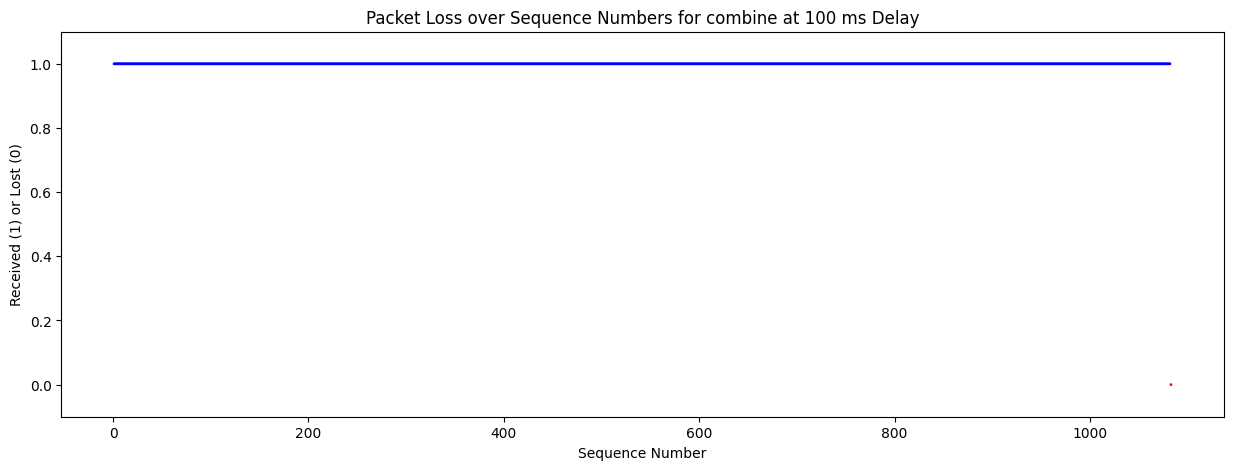

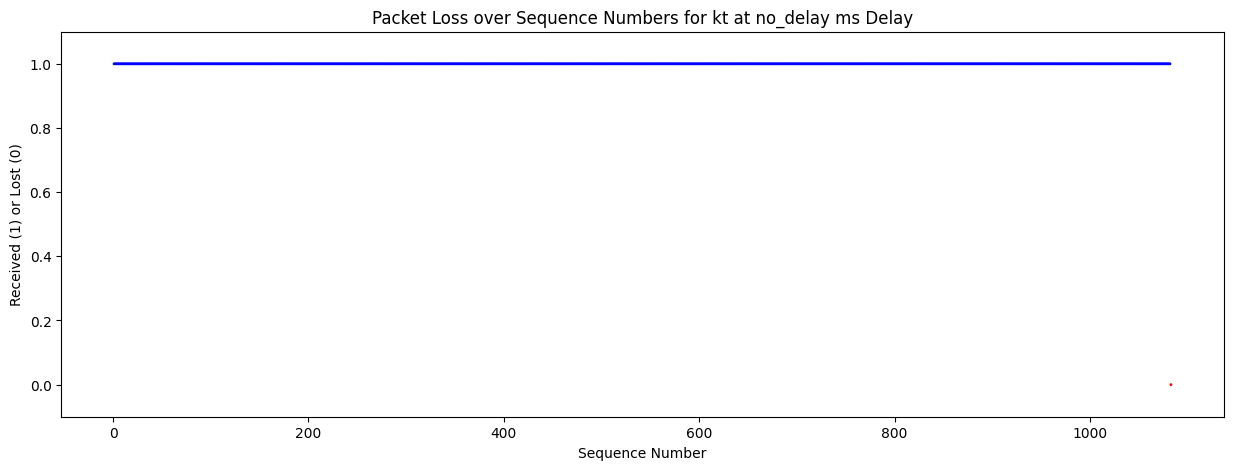

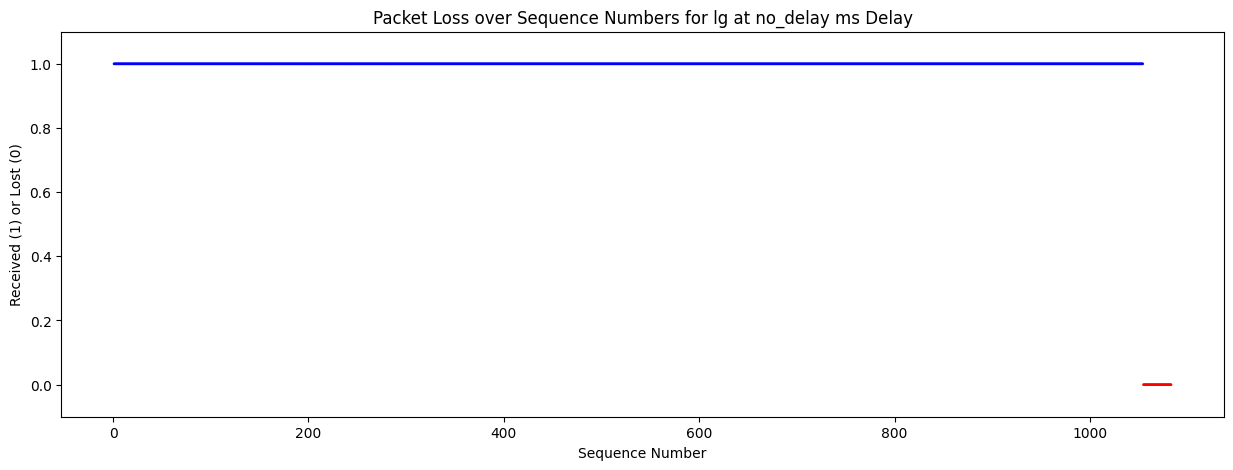

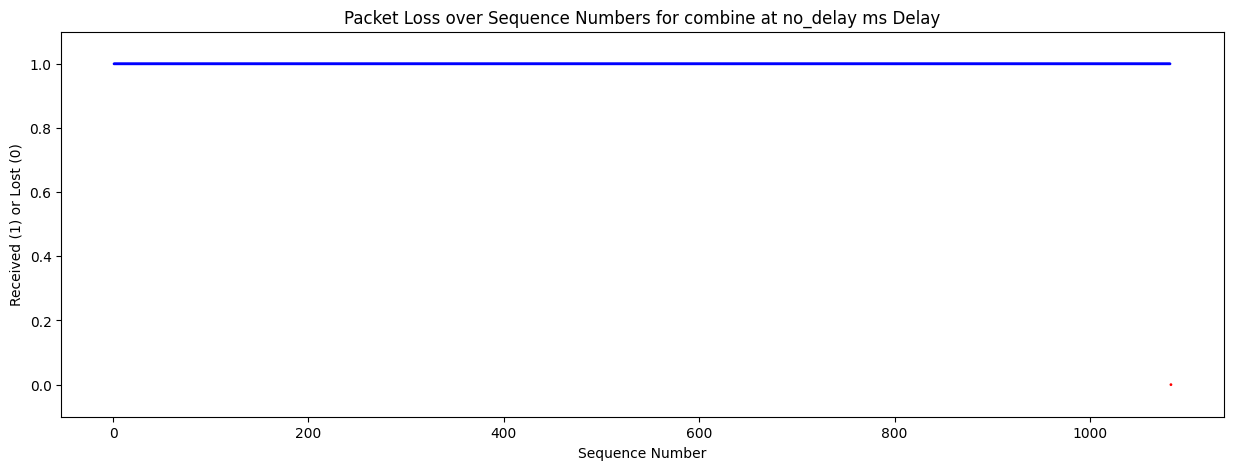

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_loss_over_sequence(log_df, total_sequence, delay, condition):
    # Create a DataFrame with sequence numbers from 1 to total_sequence
    sequence_df = pd.DataFrame({'sequence number': range(1, total_sequence + 1)})
    
    delay_col = f'is_use_{delay}'
    
    # Get the sequence numbers of received packets
    received_sequences = log_df[log_df[delay_col] == 1]['sequence number'].unique()
    
    # Merge to get a 'received' column
    sequence_df['received'] = sequence_df['sequence number'].isin(received_sequences).astype(int)
    
    # Plot the received/lost over sequence number
    plt.figure(figsize=(15, 5))
    plt.scatter(sequence_df['sequence number'], sequence_df['received'], 
                c=sequence_df['received'].map({1: 'blue', 0: 'red'}), s=1)
    plt.title(f'Packet Loss over Sequence Numbers for {condition} at {delay} ms Delay')
    plt.xlabel('Sequence Number')
    plt.ylabel('Received (1) or Lost (0)')
    plt.ylim(-0.1, 1.1)
    plt.savefig(f'{GRAPH_PATH}/loss_sequence_{condition}_{delay}.png')
    plt.show()

def plot_loss_over_sequence_numbers(kt_log_df, lg_log_df, combine_log_df, total_sequence, delays):
    conditions = ['kt', 'lg', 'combine']
    log_dfs = [kt_log_df, lg_log_df, combine_log_df]
    
    for delay in delays:
        for condition, log_df in zip(conditions, log_dfs):
            plot_loss_over_sequence(log_df, total_sequence, delay, condition)

# Assuming the DataFrames are already loaded as in your code
# combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
# sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)
# kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
# lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)

total_sequence = sending_log_df.shape[0]    # Total number of sent messages
delays = [33, 50, 100, 'no_delay']

plot_loss_over_sequence_numbers(kt_log_df, lg_log_df, combined_log_df, total_sequence, delays)


### Measure average latency

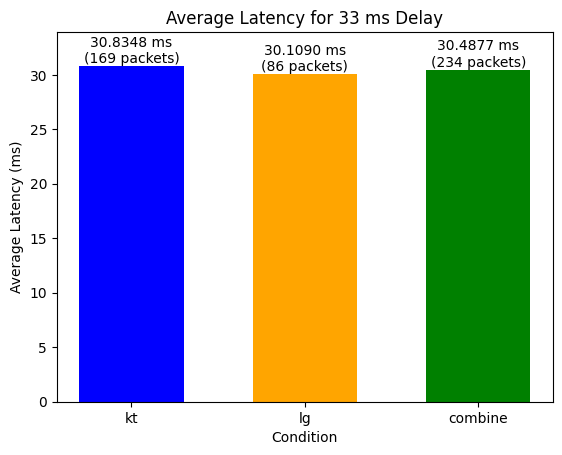

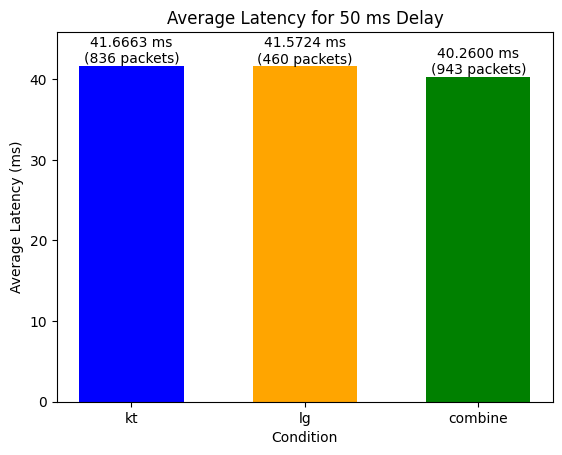

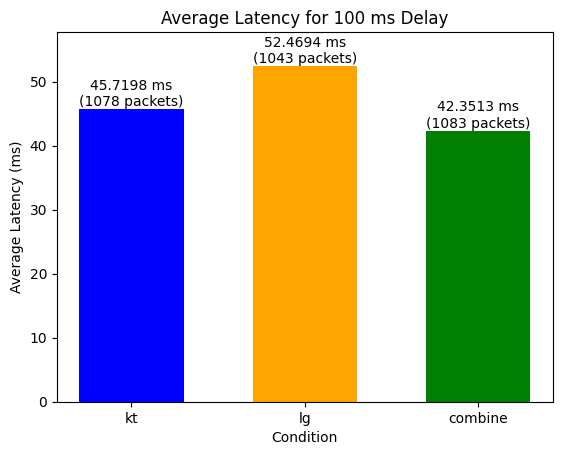

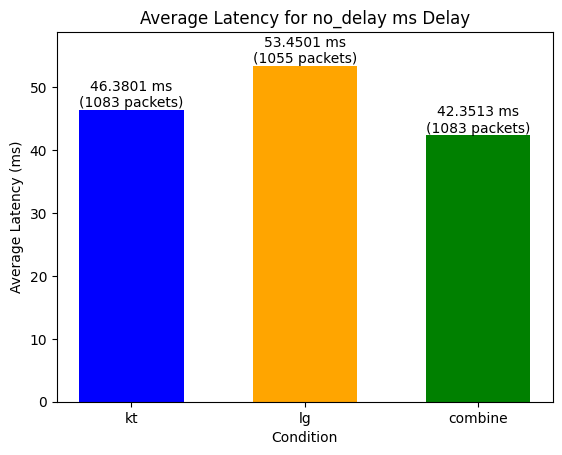

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_average_latency(log_df, delay_col, latency_col):
    # is_use_{delay}가 True인 경우의 latency 값을 추출
    valid_latencies = log_df[log_df[delay_col] == True][latency_col]
    # 평균 latency 계산
    average_latency = valid_latencies.mean()
    return average_latency, len(valid_latencies)

def plot_latency_by_delay(kt_log_df, lg_log_df, combine_log_df, delays, graph_path):
    log_dfs = [kt_log_df, lg_log_df, combine_log_df]
    labels = ['kt', 'lg', 'combine']
    
    for delay in delays:
        average_latencies = []
        count_list = []
        
        for log_df in log_dfs:
            delay_col = f'is_use_{delay}'
            latency_col = f'network_latency_ms'
            average_latency, count = calculate_average_latency(log_df, delay_col, latency_col)
            average_latencies.append(average_latency)
            count_list.append(count)
        
        # Plotting for the current delay
        x = np.arange(len(labels))
        width = 0.6  # width of the bars
        
        fig, ax = plt.subplots()
        ax.bar(x, average_latencies, width, color=['blue', 'orange', 'green'])
        
        # Annotating the bars with the average latency and the count of valid packets
        for i, (average_latency, count) in enumerate(zip(average_latencies, count_list)):
            ax.text(i, average_latency + 0.01, 
                    f'{average_latency:.4f} ms\n({count} packets)',
                    ha='center', va='bottom', fontsize=10)
        
        # Labeling and formatting the plot
        ax.set_xlabel('Condition')
        ax.set_ylabel('Average Latency (ms)')
        ax.set_title(f'Average Latency for {delay} ms Delay')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0, max(average_latencies) * 1.1)  # Set y-axis limit with a margin
        
        # Save the plot to a file
        plt.savefig(f'{graph_path}/latency_{delay}.png')
        
        # Display the plot
        plt.show()

# Example usage
combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)  # KT 로그 파일 경로 지정
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)  # LG 로그 파일 경로 지정

delays = [33, 50, 100, 'no_delay']

plot_latency_by_delay(kt_log_df, lg_log_df, combined_log_df, delays, GRAPH_PATH)


### Plot latency

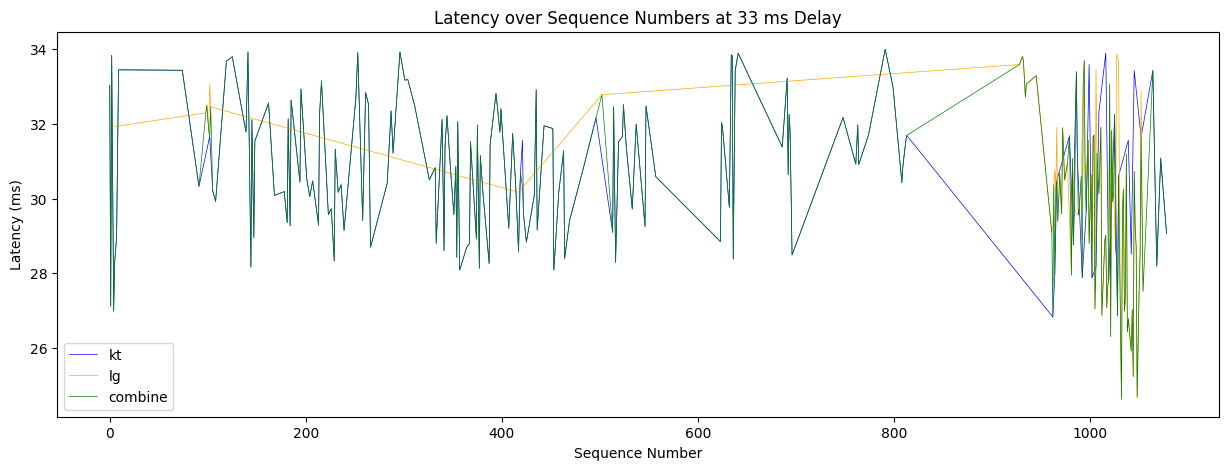

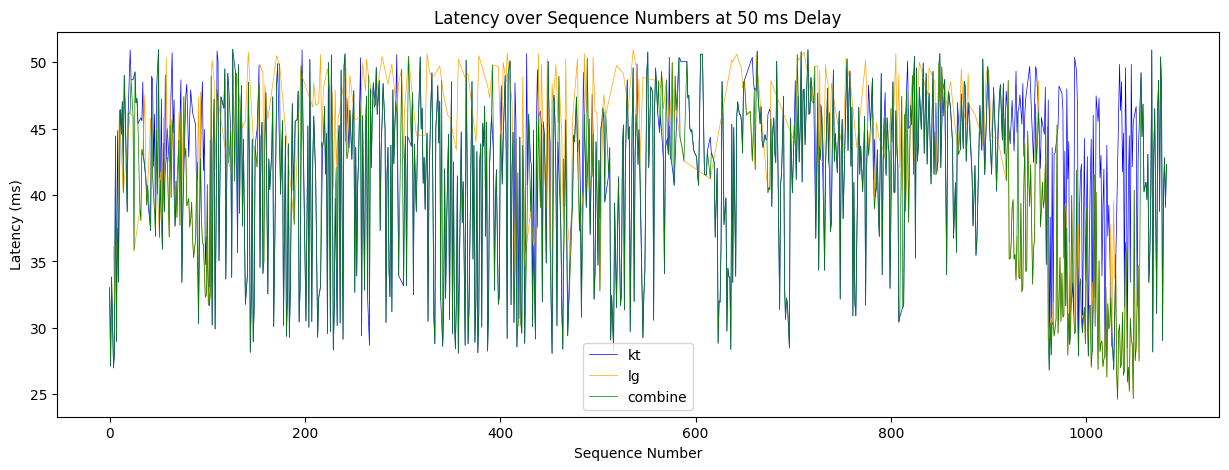

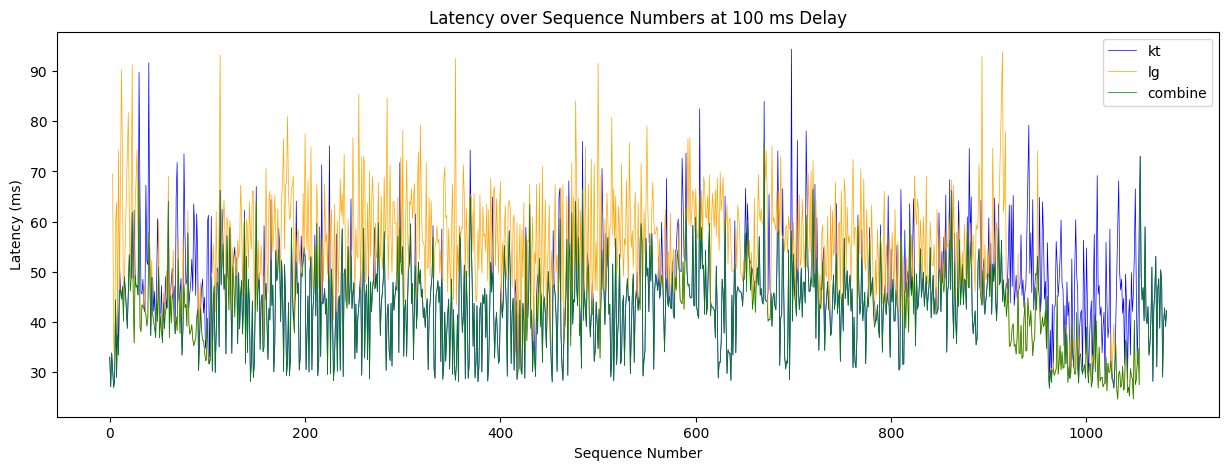

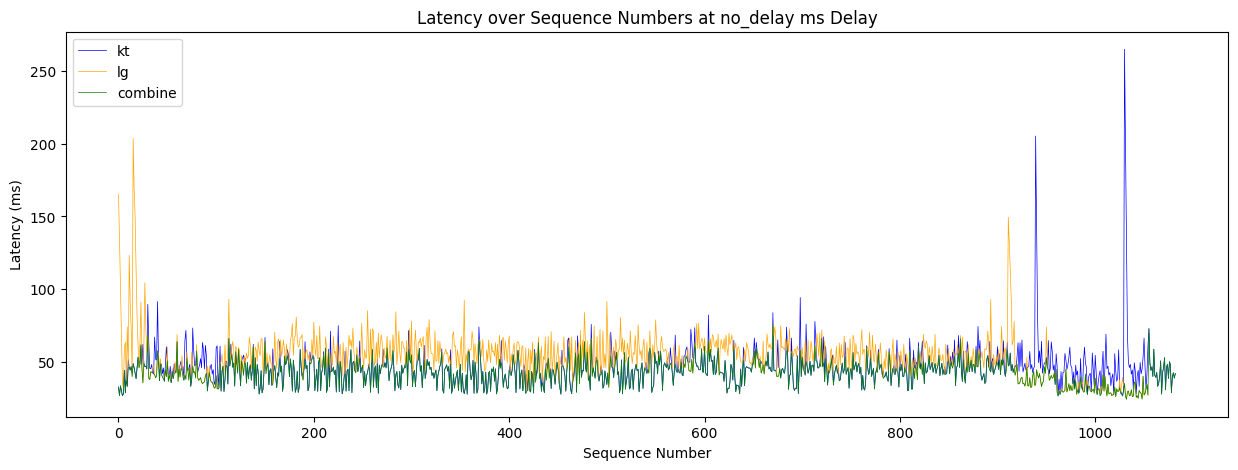

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_latency_over_sequence_numbers(kt_log_df, lg_log_df, combine_log_df, delays):
    conditions = ['kt', 'lg', 'combine']
    log_dfs = [kt_log_df, lg_log_df, combine_log_df]
    colors = ['blue', 'orange', 'green']
    
    for delay in delays:
        plt.figure(figsize=(15, 5))
        
        for condition, log_df, color in zip(conditions, log_dfs, colors):
            delay_col = f'is_use_{delay}'
            latency_col = 'network_latency_ms'
            
            # 'is_use_{delay}'가 True인 행 선택
            valid_rows = log_df[log_df[delay_col] == True]
            
            # 시퀀스 번호로 데이터 정렬
            valid_rows = valid_rows.sort_values(by='sequence number')
            
            sequence_numbers = valid_rows['sequence number']
            latencies = valid_rows[latency_col]
            
            # 라인 플롯으로 레이턴시 그리기
            plt.plot(sequence_numbers, latencies, label=condition, color=color, lw=0.5)
            # plt.scatter(sequence_numbers, latencies, s=2, label=condition, color=color)

        
        plt.title(f'Latency over Sequence Numbers at {delay} ms Delay')
        plt.xlabel('Sequence Number')
        plt.ylabel('Latency (ms)')
        plt.legend()
        plt.savefig(f'{GRAPH_PATH}/latency_sequence_{delay}.png')
        plt.show()

# 데이터프레임이 이미 로드되었다고 가정
# combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
# sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)
# kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
# lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)

delays = [33, 50, 100, 'no_delay']

plot_latency_over_sequence_numbers(kt_log_df, lg_log_df, combined_log_df, delays)


### Rename the client frame files (for measuring SSIM, PSNR)

In [115]:
import os
import shutil

# 원본 frames 폴더 경로
frames_folder = os.path.expanduser(f"{CLIENT_FILEPATH}frames")
# 새로 생성할 frames_with_sequence 폴더 경로
destination_folder = os.path.expanduser(f"{CLIENT_FILEPATH}frames_with_sequence")

# frames_with_sequence 폴더가 없으면 생성
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# frames 폴더 내의 파일들을 가져옴
files = [f for f in os.listdir(frames_folder) if f.endswith(".png")]

# 파일들을 타임스탬프 기준으로 정렬
files.sort(key=lambda x: int(x.split('.')[0]))

# 시퀀스 넘버를 2부터 시작
# 2부터 시작하고, len(files) - 15로 하는건, 현재 설정에서 디코더 및 인코더에 들어있는 것들을 manual하게 제외해줌
# 나중에 수정 필요 ....
sequence_number = 0
final_sequence_number = len(files) - 1 # 0부터 시작

# 파일들을 순서대로 복사하며 이름 변경
for file_name in files:
    if sequence_number <= final_sequence_number:
        timestamp = file_name.split('.')[0]
        new_file_name = f"{sequence_number}_{timestamp}.png"
        src_path = os.path.join(frames_folder, file_name)
        dst_path = os.path.join(destination_folder, new_file_name)
        shutil.copy(src_path, dst_path)
        sequence_number += 1

print("Files have been successfully copied and renamed.")


Files have been successfully copied and renamed.


### Message size <-> Network latency

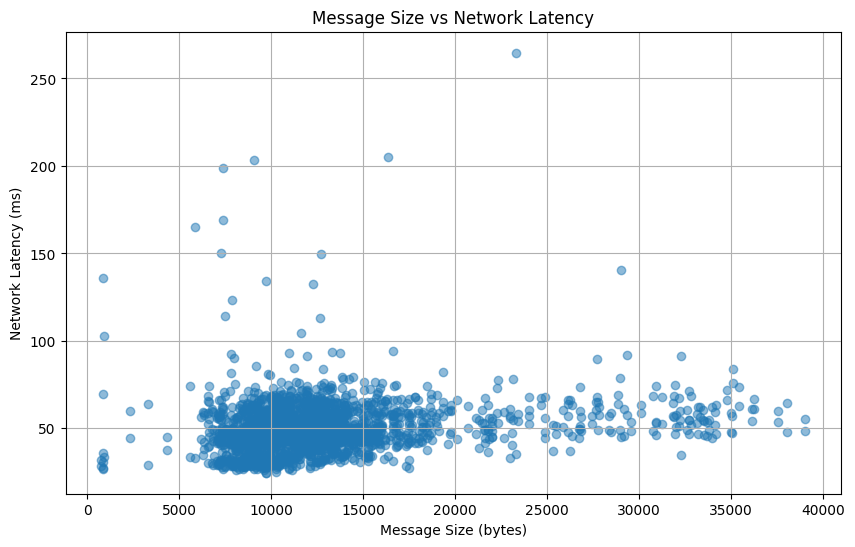

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import os


def plot_message_size_vs_latency(kt_log_df, lg_log_df):
    # Combine the data frames
    combined_df = pd.concat([kt_log_df, lg_log_df], ignore_index=True)
    
    # Ensure the required columns exist
    if 'message size' not in combined_df.columns or 'network_latency_ms' not in combined_df.columns:
        print("Required columns are missing in the data frames.")
        return
    
    # Extract the required columns
    message_sizes = combined_df['message size']
    latencies = combined_df['network_latency_ms']
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(message_sizes, latencies, alpha=0.5)
    plt.title('Message Size vs Network Latency')
    plt.xlabel('Message Size (bytes)')
    plt.ylabel('Network Latency (ms)')
    plt.grid(True)
    plt.savefig(f'{GRAPH_PATH}/message_size_vs_latency.png')
    plt.show()

# Assuming the DataFrames are already loaded as in your code
# combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
# kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
# lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)

plot_message_size_vs_latency(kt_log_df, lg_log_df)


### Measuring SSIM, PSNR

In [10]:
# import os
# import cv2
# import numpy as np
# import pandas as pd
# from skimage.metrics import structural_similarity as ssim
# import matplotlib.pyplot as plt

# # 경로 설정
# original_folder = f"{CLIENT_FILEPATH}frames_with_sequence"

# # delay 목록 설정
# delays = [33, 50, 100, "no_delay"]
# labels = ['kt', 'lg', 'combine']

# # log_df
# log_dfs = [kt_log_df, lg_log_df, combined_log_df]

# # 전체 재생 시간 계산 함수
# def calculate_total_duration(original_folder):
#     original_files = [f for f in os.listdir(original_folder) if f.endswith(".png")]
#     original_files.sort(key=lambda x: int(x.split('_')[0]))

#     start_time = int(original_files[0].split('_')[1].split('.')[0])
#     end_time = int(original_files[-1].split('_')[1].split('.')[0])
    
#     total_duration = (end_time - start_time) / 1e6  # Convert microseconds to seconds
#     return total_duration, len(original_files)

# # 두 이미지를 비교하여 SSIM과 PSNR을 반환하는 함수
# def compare_images(img1, img2):
#     ssim_value = ssim(img1, img2, channel_axis=-1)
#     psnr_value = cv2.PSNR(img1, img2)
#     return ssim_value, psnr_value

# # 전체 재생 시간과 원본 이미지의 프레임 수 계산
# total_duration, original_frame_count = calculate_total_duration(original_folder)

# # original file의 FPS 계산
# original_fps = original_frame_count / total_duration

# # 결과를 저장할 딕셔너리 초기화
# results = {
#     delay: {
#         "kt": {"ssim": [], "psnr": [], "count": 0},
#         "lg": {"ssim": [], "psnr": [], "count": 0},
#         "combine": {"ssim": [], "psnr": [], "count": 0},
#     } for delay in delays
# }

# # 비교 수행
# for label in labels:
#     for delay in delays:
#         compare_folder = f"{FRAMES_FILEPATH}/{label}_delay_{delay}"
#         if not os.path.exists(compare_folder):
#             print(f"Folder {compare_folder} does not exist. Skipping...")
#             continue
#         compare_files = [f for f in os.listdir(compare_folder) if f.endswith(".png")]

#         for compare_file in compare_files:
#             sequence_number = compare_file.split('_')[0]

#             # 원본 이미지 로드
#             original_file = next((f for f in os.listdir(original_folder) if f.startswith(f"{sequence_number}_")), None)
#             original_img = cv2.imread(os.path.join(original_folder, original_file))
            
#             # 비교할 이미지 로드
#             compare_img = cv2.imread(os.path.join(compare_folder, compare_file))
            
#             if original_img is not None and compare_img is not None:
#                 # SSIM, PSNR 계산
#                 ssim_value, psnr_value = compare_images(original_img, compare_img)
                
#                 # 결과 저장
#                 results[delay][label]["ssim"].append(ssim_value)
#                 results[delay][label]["psnr"].append(psnr_value)
#                 results[delay][label]["count"] += 1
#             else:
#                 print(f"Missing image for sequence {sequence_number} in {label} method with delay {delay}.")

# # FPS 계산 및 그래프 출력
# for delay in delays:
#     ssim_values = []
#     psnr_values = []
#     frame_counts = []
#     fps_values = []

#     for label in labels:
#         ssim_avg = sum(results[delay][label]["ssim"]) / len(results[delay][label]["ssim"]) if results[delay][label]["ssim"] else 0
#         psnr_avg = sum(results[delay][label]["psnr"]) / len(results[delay][label]["psnr"]) if results[delay][label]["psnr"] else 0
#         frame_count = results[delay][label]["count"]
#         fps = frame_count / total_duration
        
#         ssim_values.append(ssim_avg)
#         psnr_values.append(psnr_avg)
#         frame_counts.append(frame_count)
#         fps_values.append(fps)
        
#         print(f"Results for {label} with delay {delay}:")
#         print(f"Average SSIM: {ssim_avg:.4f}")
#         print(f"Average PSNR: {psnr_avg:.2f} dB")
#         print(f"Frame Count: {frame_count}")
#         print(f"FPS: {fps:.2f}\n")
    
#     # 그래프 그리기
#     x = np.arange(len(labels))
#     width = 0.35
    
#     fig, ax1 = plt.subplots(figsize=(10, 6))
    
#     # SSIM 바 그래프
#     ax1.bar(x - width/2, ssim_values, width, label='SSIM', color='b')
#     ax1.set_ylabel('Average SSIM')
#     ax1.set_ylim(0, 1)
    
#     # PSNR 바 그래프 (오른쪽 y축)
#     ax2 = ax1.twinx()
#     ax2.bar(x + width/2, psnr_values, width, label='PSNR', color='r')
#     ax2.set_ylabel('Average PSNR (dB)')
    
#     # X축 및 제목 설정
#     ax1.set_xlabel('Carriers')
#     ax1.set_title(f'Image Quality Comparison for Delay {delay}')
#     ax1.set_xticks(x)
#     ax1.set_xticklabels([f"{label}\n(FPS={fps_values[i]:.2f}, n={frame_counts[i]})" for i, label in enumerate(labels)])
    
#     fig.tight_layout()
    
#     # 범례 추가
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
    
#     # 그래프를 delay 별로 저장
#     plt.savefig(f"{GRAPH_PATH}/visual_quality_delay_{delay}.png")
#     plt.show()

#     print(f"\n\nOriginal FPS: {original_fps}")

Folder /home/songmu/Multipath/cpp/results/server/2024_09_27_13_44/frames/kt_delay_33 does not exist. Skipping...


KeyboardInterrupt: 

### Measuring SSIM, PSNR (No decoded image -> SSIM, PSNR = 0)

Results for kt with delay 33:
Average SSIM: 0.0135
Average PSNR: 0.54 dB
Frame Count: 29
FPS: 0.43

Results for lg with delay 33:
Average SSIM: 0.0102
Average PSNR: 0.36 dB
Frame Count: 13
FPS: 0.19

Results for combine with delay 33:
Average SSIM: 0.0278
Average PSNR: 1.04 dB
Frame Count: 48
FPS: 0.71



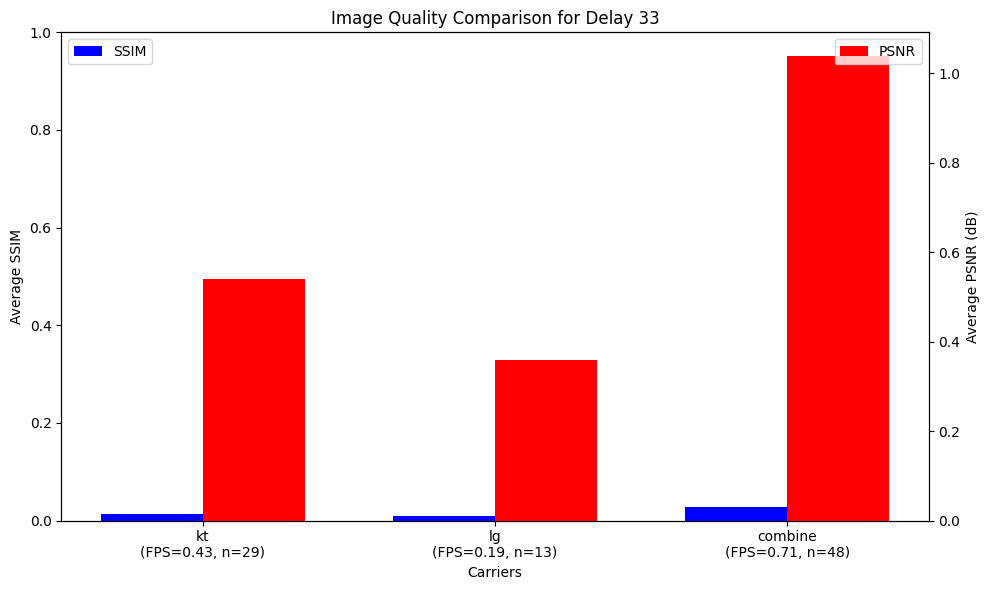



Original FPS: 16.022477272049414
Results for kt with delay 50:
Average SSIM: 0.3276
Average PSNR: 11.65 dB
Frame Count: 446
FPS: 6.60

Results for lg with delay 50:
Average SSIM: 0.1662
Average PSNR: 6.13 dB
Frame Count: 231
FPS: 3.42

Results for combine with delay 50:
Average SSIM: 0.4985
Average PSNR: 18.49 dB
Frame Count: 649
FPS: 9.60



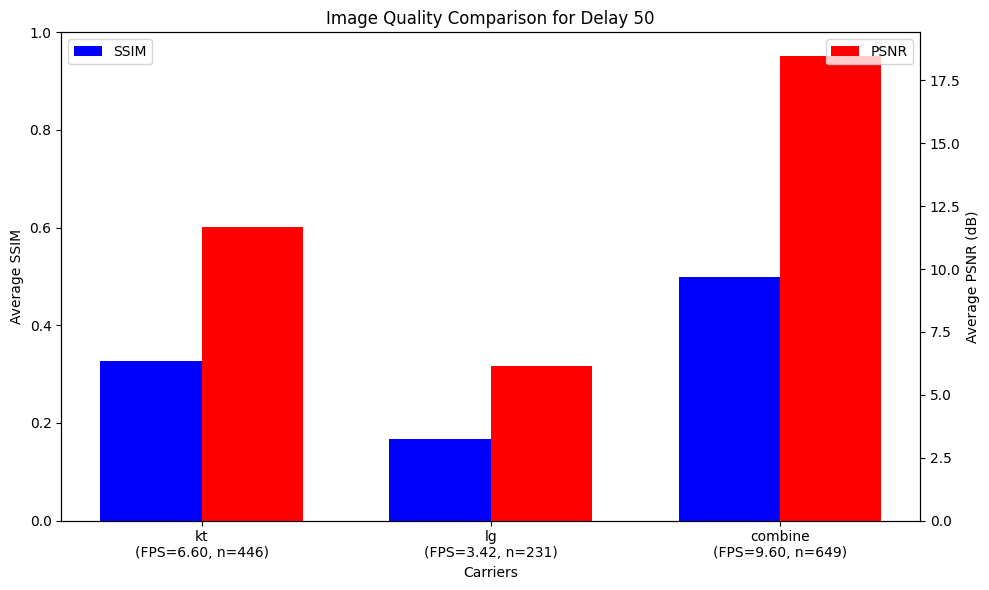



Original FPS: 16.022477272049414
Results for kt with delay 100:
Average SSIM: 0.8644
Average PSNR: 33.91 dB
Frame Count: 1065
FPS: 15.76

Results for lg with delay 100:
Average SSIM: 0.8383
Average PSNR: 32.75 dB
Frame Count: 1036
FPS: 15.33

Results for combine with delay 100:
Average SSIM: 0.8798
Average PSNR: 34.52 dB
Frame Count: 1083
FPS: 16.02



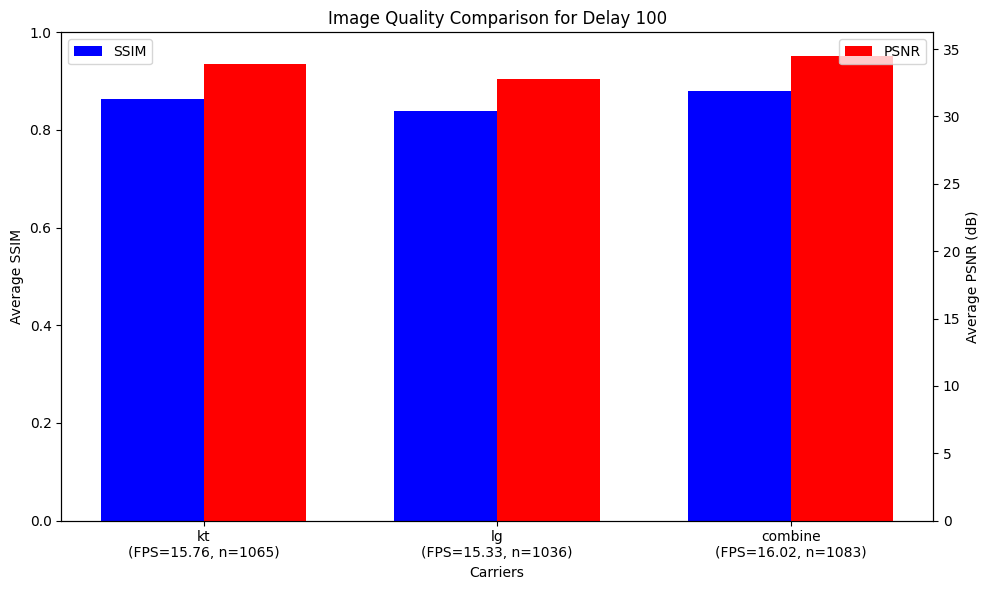



Original FPS: 16.022477272049414
Results for kt with delay no_delay:
Average SSIM: 0.8798
Average PSNR: 34.52 dB
Frame Count: 1083
FPS: 16.02

Results for lg with delay no_delay:
Average SSIM: 0.8562
Average PSNR: 33.59 dB
Frame Count: 1055
FPS: 15.61

Results for combine with delay no_delay:
Average SSIM: 0.8798
Average PSNR: 34.52 dB
Frame Count: 1083
FPS: 16.02



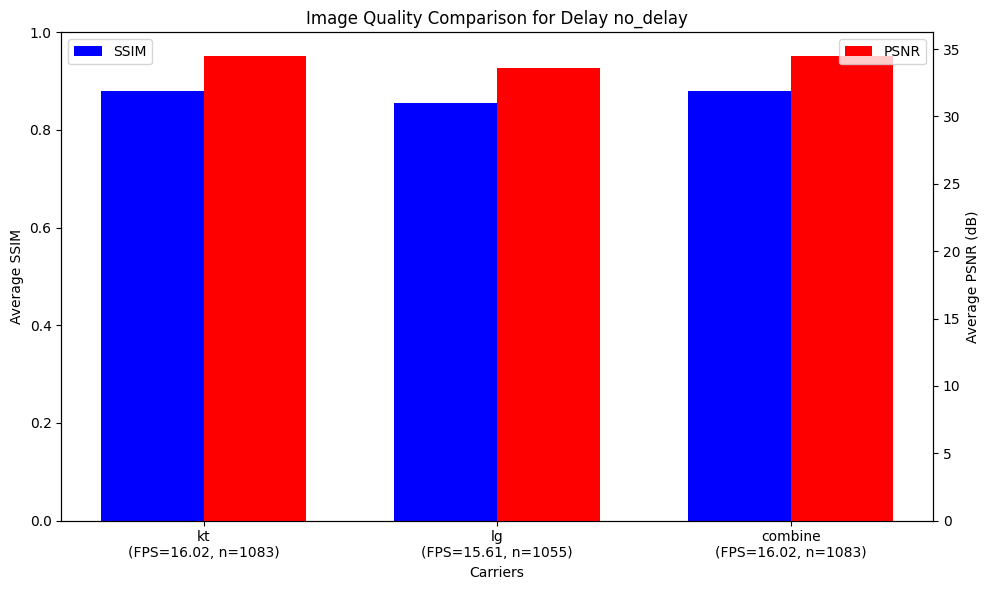



Original FPS: 16.022477272049414


In [117]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# 경로 설정
original_folder = f"{CLIENT_FILEPATH}frames_with_sequence"

# delay 목록 설정
delays = [33, 50, 100, "no_delay"]
labels = ['kt', 'lg', 'combine']

# log_df
log_dfs = [kt_log_df, lg_log_df, combined_log_df]

# 전체 재생 시간 계산 함수
def calculate_total_duration(original_folder):
    original_files = [f for f in os.listdir(original_folder) if f.endswith(".png")]
    original_files.sort(key=lambda x: int(x.split('_')[0]))

    start_time = int(original_files[0].split('_')[1].split('.')[0])
    end_time = int(original_files[-1].split('_')[1].split('.')[0])
    
    total_duration = (end_time - start_time) / 1e6  # Convert microseconds to seconds
    return total_duration, len(original_files)

# 두 이미지를 비교하여 SSIM과 PSNR을 반환하는 함수
def compare_images(img1, img2):
    ssim_value = ssim(img1, img2, channel_axis=-1)
    psnr_value = cv2.PSNR(img1, img2)
    return ssim_value, psnr_value

# 전체 재생 시간과 원본 이미지의 프레임 수 계산
total_duration, original_frame_count = calculate_total_duration(original_folder)

# original file의 FPS 계산
original_fps = original_frame_count / total_duration

# 결과를 저장할 딕셔너리 초기화
results = {
    delay: {
        "kt": {"ssim": [], "psnr": [], "count": 0},
        "lg": {"ssim": [], "psnr": [], "count": 0},
        "combine": {"ssim": [], "psnr": [], "count": 0},
    } for delay in delays
}

# original folder에 있는 모든 시퀀스 번호를 가져옴
original_files = [f for f in os.listdir(original_folder) if f.endswith(".png")]
original_files.sort(key=lambda x: int(x.split('_')[0]))
sequence_numbers = [f.split('_')[0] for f in original_files]

# 비교 수행
for label in labels:
    for delay in delays:
        compare_folder = f"{FRAMES_FILEPATH}/{label}_delay_{delay}"
        if not os.path.exists(compare_folder):
            print(f"Folder {compare_folder} does not exist. Skipping...")
            continue
        compare_files = {f.split('_')[0]: f for f in os.listdir(compare_folder) if f.endswith(".png")}

        for sequence_number in sequence_numbers:
            # 원본 이미지 로드
            original_file = next((f for f in original_files if f.startswith(f"{sequence_number}_")), None)
            original_img = cv2.imread(os.path.join(original_folder, original_file))
            
            # 비교할 이미지 로드
            compare_file = compare_files.get(sequence_number, None)
            compare_img = cv2.imread(os.path.join(compare_folder, compare_file)) if compare_file else None
            
            if original_img is not None and compare_img is not None:
                # SSIM, PSNR 계산
                ssim_value, psnr_value = compare_images(original_img, compare_img)
                results[delay][label]["count"] += 1
            else:
                # 이미지가 없는 경우 SSIM, PSNR을 0으로 설정
                ssim_value, psnr_value = 0, 0
                
            # 결과 저장
            results[delay][label]["ssim"].append(ssim_value)
            results[delay][label]["psnr"].append(psnr_value)

# FPS 계산 및 그래프 출력
for delay in delays:
    ssim_values = []
    psnr_values = []
    frame_counts = []
    fps_values = []

    for label in labels:
        ssim_avg = sum(results[delay][label]["ssim"]) / len(results[delay][label]["ssim"]) if results[delay][label]["ssim"] else 0
        psnr_avg = sum(results[delay][label]["psnr"]) / len(results[delay][label]["psnr"]) if results[delay][label]["psnr"] else 0
        frame_count = results[delay][label]["count"]
        fps = frame_count / total_duration
        
        ssim_values.append(ssim_avg)
        psnr_values.append(psnr_avg)
        frame_counts.append(frame_count)
        fps_values.append(fps)
        
        print(f"Results for {label} with delay {delay}:")
        print(f"Average SSIM: {ssim_avg:.4f}")
        print(f"Average PSNR: {psnr_avg:.2f} dB")
        print(f"Frame Count: {frame_count}")
        print(f"FPS: {fps:.2f}\n")
    
    # 그래프 그리기
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # SSIM 바 그래프
    ax1.bar(x - width/2, ssim_values, width, label='SSIM', color='b')
    ax1.set_ylabel('Average SSIM')
    ax1.set_ylim(0, 1)
    
    # PSNR 바 그래프 (오른쪽 y축)
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, psnr_values, width, label='PSNR', color='r')
    ax2.set_ylabel('Average PSNR (dB)')
    
    # X축 및 제목 설정
    ax1.set_xlabel('Carriers')
    ax1.set_title(f'Image Quality Comparison for Delay {delay}')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{label}\n(FPS={fps_values[i]:.2f}, n={frame_counts[i]})" for i, label in enumerate(labels)])
    
    fig.tight_layout()
    
    # 범례 추가
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # 그래프를 delay 별로 저장
    plt.savefig(f"{GRAPH_PATH}/visual_quality_delay_{delay}.png")
    plt.show()

    print(f"\n\nOriginal FPS: {original_fps}")


### Draw graphs for ssim, psnr

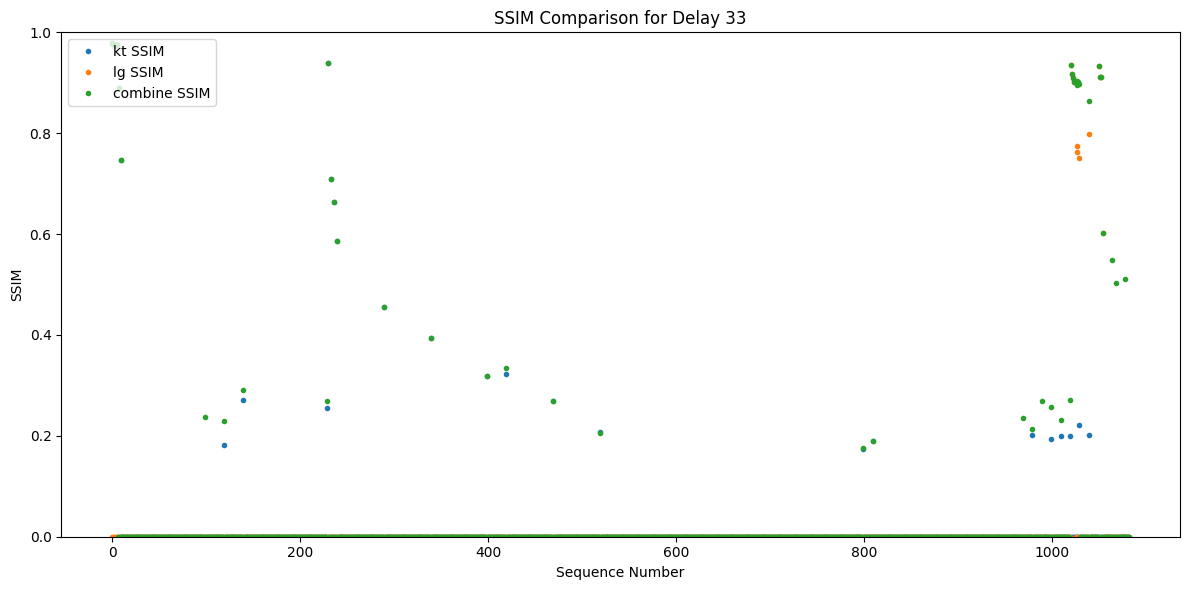

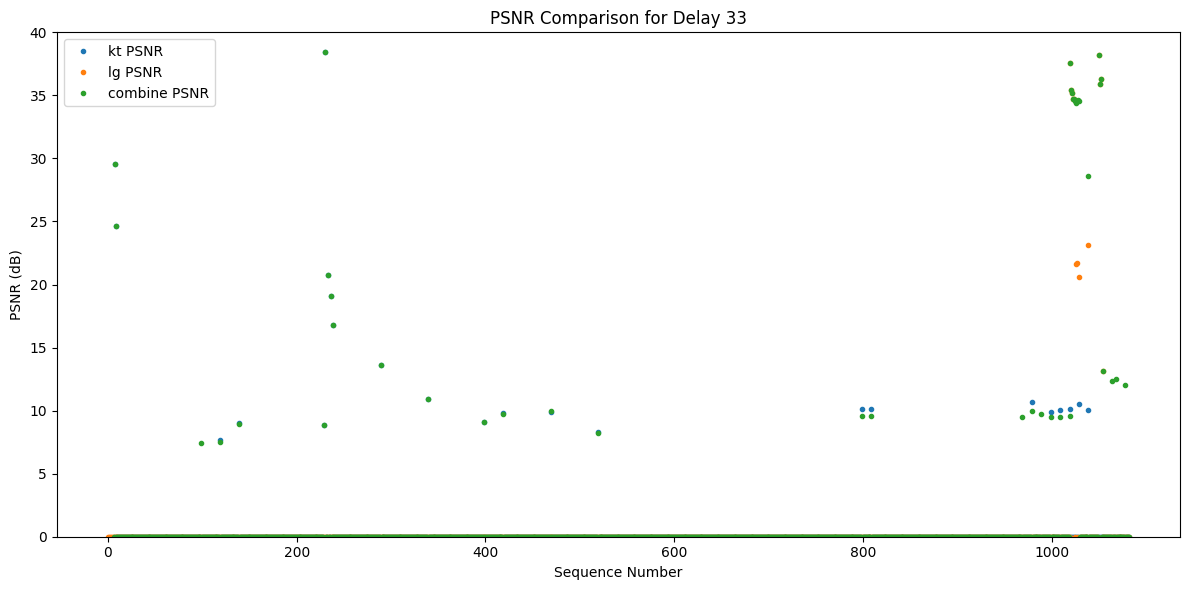

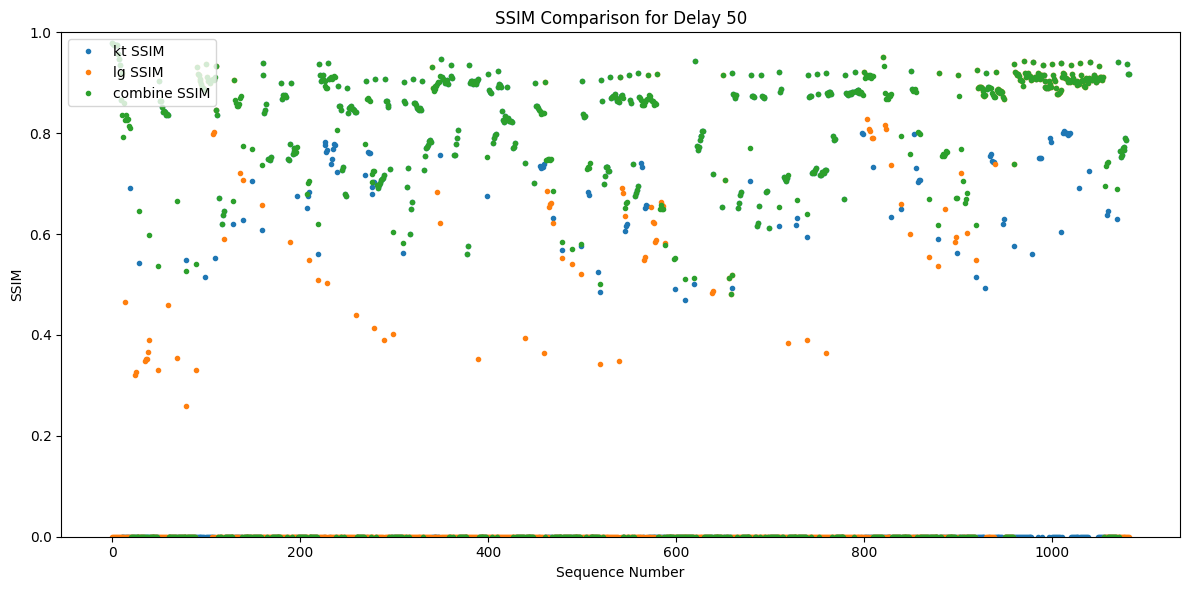

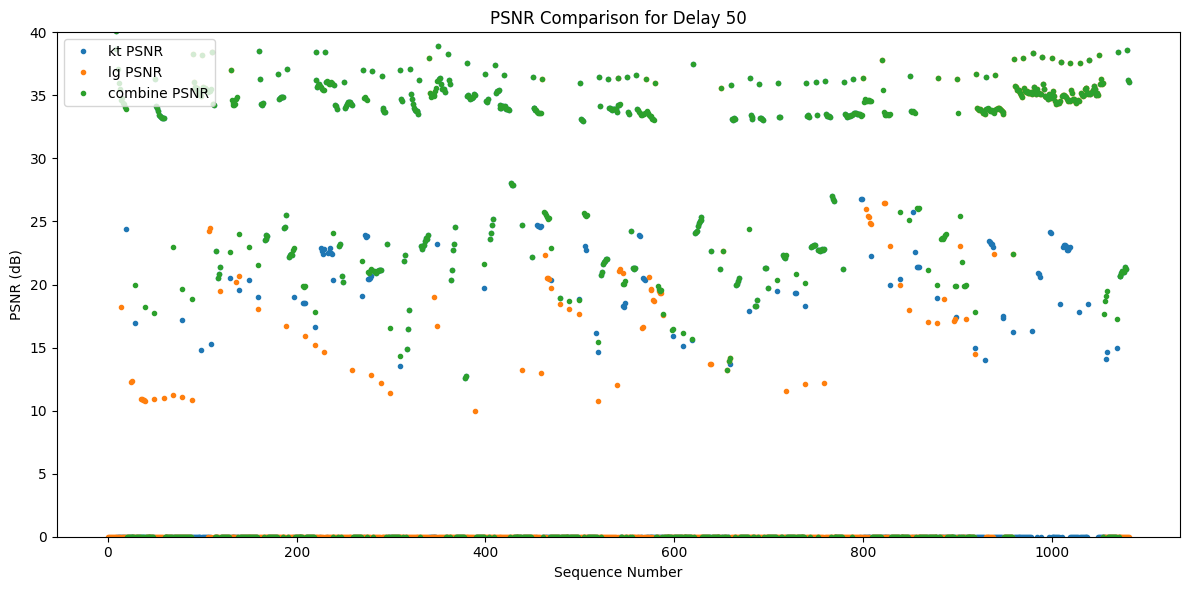

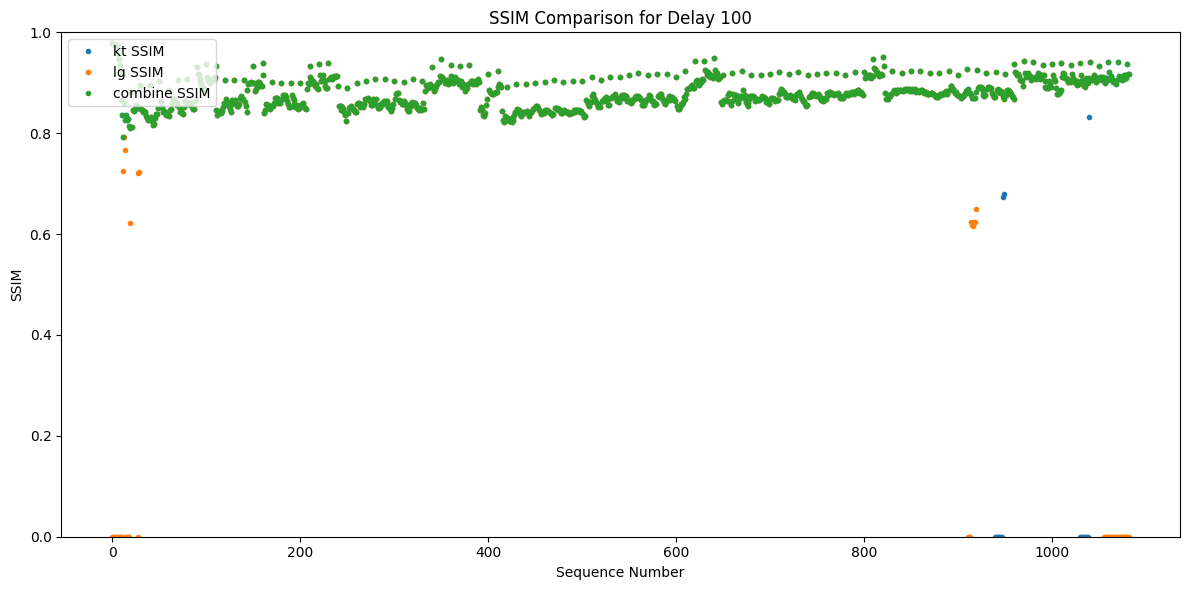

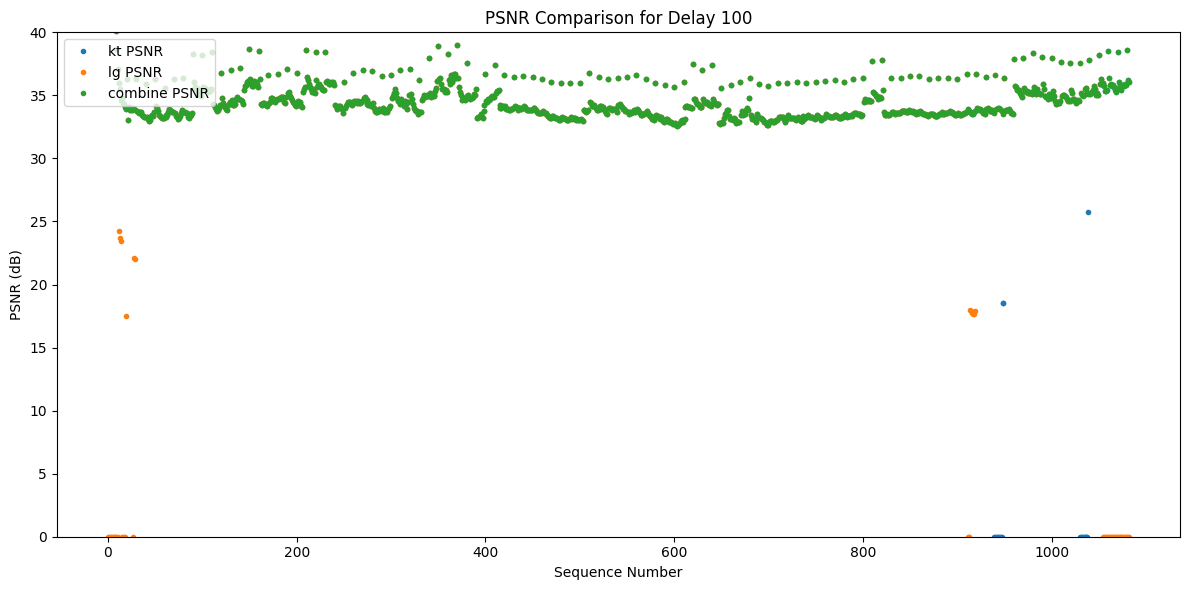

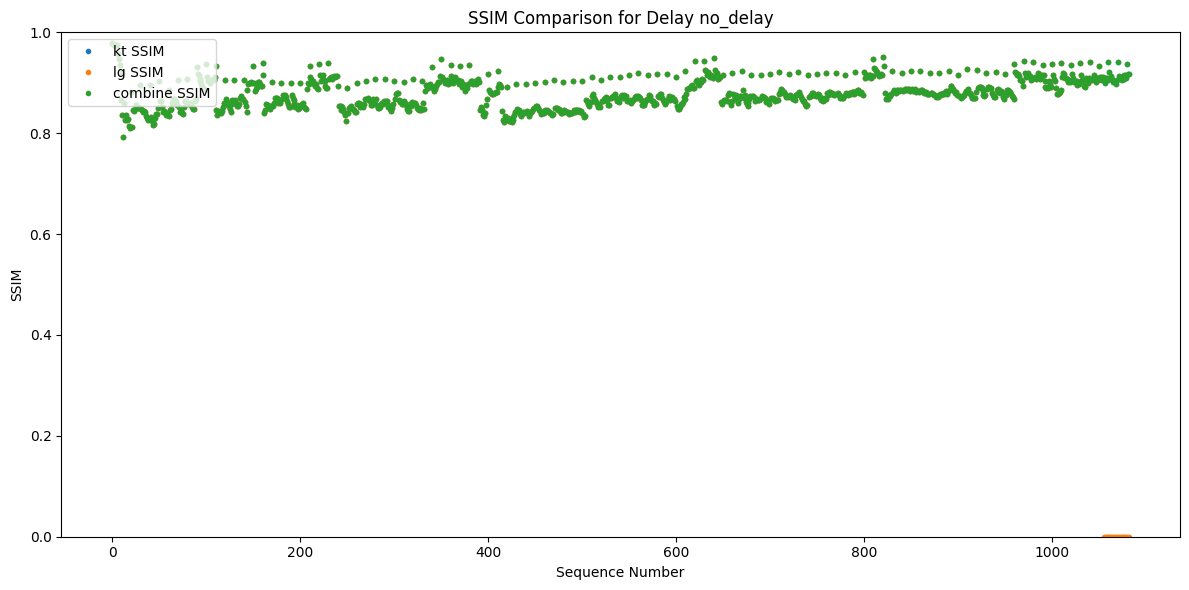

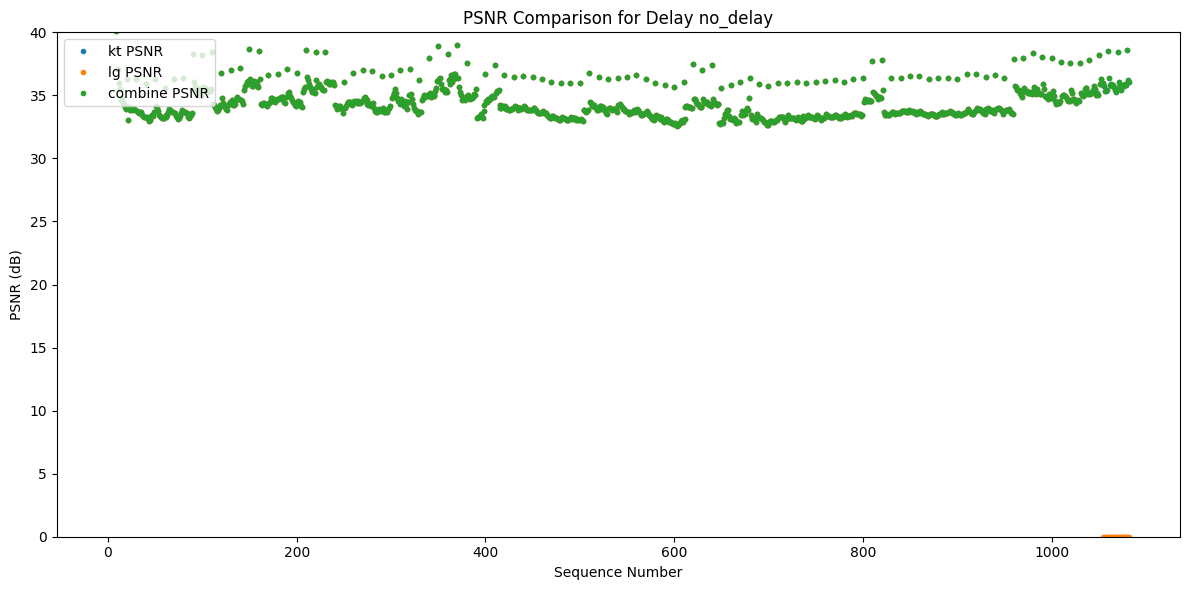

In [118]:
import matplotlib.pyplot as plt

# 딜레이 별로 그래프 그리기

for delay in delays:
    sequence_numbers = list(range(len(results["no_delay"]['combine']['ssim'])))  # 시퀀스 번호에 해당하는 x축 값
    # 그래프 그리기
    plt.figure(figsize=(12, 6))

    # SSIM 그래프 그리기
    for label in labels:
        # sequence_numbers = [i for i, ssim in enumerate(results[delay][label]["ssim"]) if ssim != 0]
        # ssim_values_without_0 = [ssim for ssim in results[delay][label]["ssim"] if ssim != 0]
        ssim_values = results[delay][label]["ssim"]
        # print(ssim_values)
        # print(len(results[delay][label]["ssim"]))
        if ssim_values:  # 리스트가 비어있지 않은 경우에만 플롯
            plt.plot(sequence_numbers, ssim_values, marker='o', markersize = 3, linestyle='None', label=f'{label} SSIM')

    plt.xlabel('Sequence Number')
    plt.ylabel('SSIM')
    plt.ylim(0, 1)
    plt.title(f'SSIM Comparison for Delay {delay}')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{GRAPH_PATH}/ssim_sequence_delay_{delay}.png")
    plt.show()


    # PSNR 그래프 그리기
    plt.figure(figsize=(12, 6))
    for label in labels:
        # psnr_values_wiout_0 = [psnr for psnr in results[delay][label]["psnr"] if psnr != 0]
        # sequence_numbers = [i for i, psnr in enumerate(results[delay][label]["psnr"]) if psnr != 0]
        psnr_values = results[delay][label]["psnr"]
        if psnr_values:  # 리스트가 비어있지 않은 경우에만 플롯
            plt.plot(sequence_numbers, psnr_values, marker='o', markersize = 3, linestyle='None', label=f'{label} PSNR')
    plt.xlabel('Sequence Number')
    plt.ylabel('PSNR (dB)')
    plt.ylim(0, 40)  # PSNR 값의 범위를 설정 (필요에 따라 조정 가능)
    plt.title(f'PSNR Comparison for Delay {delay}')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{GRAPH_PATH}/psnr_sequence_delay_{delay}.png")
    plt.show()


### SSIM, PSNR 비교 (LG > COMBINE)

Delay: 33
SSIM: lg > combine in 0 out of 1083 cases
PSNR: lg > combine in 0 out of 1083 cases

Delay: 50
SSIM: lg > combine in 12 out of 1083 cases
PSNR: lg > combine in 9 out of 1083 cases

Delay: 100
SSIM: lg > combine in 0 out of 1083 cases
PSNR: lg > combine in 0 out of 1083 cases

Delay: no_delay
SSIM: lg > combine in 0 out of 1083 cases
PSNR: lg > combine in 0 out of 1083 cases



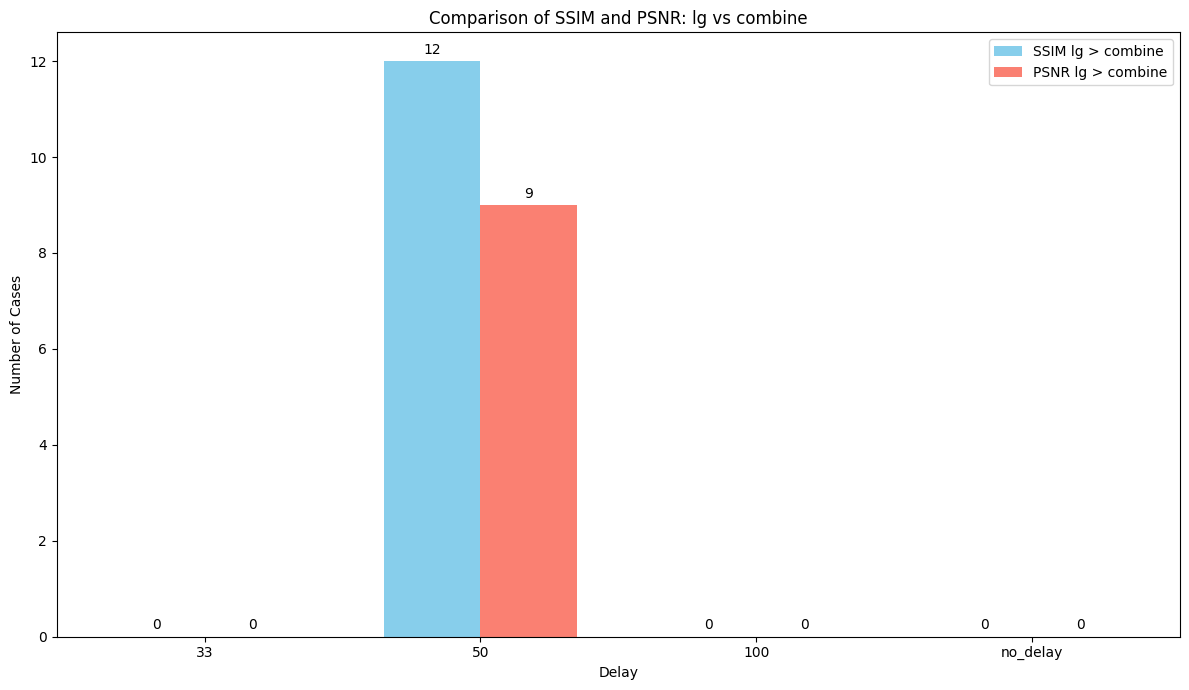

In [119]:
# "lg"가 "combine"보다 SSIM과 PSNR이 큰 경우를 비교

# 비교 결과를 저장할 딕셔너리 초기화
comparison_results = {
    delay: {
        "ssim_lg_gt_combine": 0,  # SSIM에서 lg가 combine보다 큰 경우의 수
        "psnr_lg_gt_combine": 0,  # PSNR에서 lg가 combine보다 큰 경우의 수
        "total": len(results[delay]["kt"]["ssim"])  # 총 비교한 시퀀스 수
    } for delay in delays
}

# 각 지연(delay)별로 비교 수행
for delay in delays:
    lg_ssim = results[delay]["lg"]["ssim"]
    combine_ssim = results[delay]["combine"]["ssim"]
    lg_psnr = results[delay]["lg"]["psnr"]
    combine_psnr = results[delay]["combine"]["psnr"]
    
    # SSIM 비교
    ssim_lg_gt = sum(1 for lg, cmb in zip(lg_ssim, combine_ssim) if lg > cmb)
    # PSNR 비교
    psnr_lg_gt = sum(1 for lg, cmb in zip(lg_psnr, combine_psnr) if lg > cmb)
    
    # 비교 결과 저장
    comparison_results[delay]["ssim_lg_gt_combine"] = ssim_lg_gt
    comparison_results[delay]["psnr_lg_gt_combine"] = psnr_lg_gt

    # 결과 출력
    print(f"Delay: {delay}")
    print(f"SSIM: lg > combine in {ssim_lg_gt} out of {comparison_results[delay]['total']} cases")
    print(f"PSNR: lg > combine in {psnr_lg_gt} out of {comparison_results[delay]['total']} cases\n")

# 시각화를 위한 데이터 준비
labels_to_plot = delays
ssim_counts = [comparison_results[delay]["ssim_lg_gt_combine"] for delay in labels_to_plot]
psnr_counts = [comparison_results[delay]["psnr_lg_gt_combine"] for delay in labels_to_plot]

x = np.arange(len(labels_to_plot))
width = 0.35  # 막대 너비

# 막대 그래프 생성
fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, ssim_counts, width, label='SSIM lg > combine', color='skyblue')
rects2 = ax.bar(x + width/2, psnr_counts, width, label='PSNR lg > combine', color='salmon')

# 그래프 라벨 및 제목 설정
ax.set_xlabel('Delay')
ax.set_ylabel('Number of Cases')
ax.set_title('Comparison of SSIM and PSNR: lg vs combine')
ax.set_xticks(x)
ax.set_xticklabels(labels_to_plot)
ax.legend()

# 값 라벨 추가
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 포인트 위
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# 그래프 출력
plt.show()


In [120]:
# "lg"가 "combine"보다 SSIM과 PSNR이 큰 경우를 비교

# 비교 결과를 저장할 딕셔너리 초기화
comparison_results = {
    delay: {
        "ssim_lg_gt_combine": 0,  # SSIM에서 lg가 combine보다 큰 경우의 수
        "psnr_lg_gt_combine": 0,  # PSNR에서 lg가 combine보다 큰 경우의 수
        "total": len(results[delay]["kt"]["ssim"])  # 총 비교한 시퀀스 수
    } for delay in delays
}

# 각 지연(delay)별로 비교 수행
for delay in delays:
    print(f"\n\ndelay: {delay}\n\n")
    lg_ssim = results[delay]["kt"]["ssim"]
    combine_ssim = results[delay]["combine"]["ssim"]
    lg_psnr = results[delay]["kt"]["psnr"]
    combine_psnr = results[delay]["combine"]["psnr"]
    
    # SSIM 비교
    ssim_lg_over_seq = []
    i = 0
    for lg, cmb in zip(lg_ssim, combine_ssim):
        if lg > cmb:
            ssim_lg_over_seq.append(i)
        i += 1
    # PSNR 비교
    psnr_lg_over_seq = []
    i = 0
    for lg, cmb in zip(lg_psnr, combine_psnr):
        if lg > cmb:
            psnr_lg_over_seq.append(i)
        i += 1
    print(ssim_lg_over_seq)
    print(psnr_lg_over_seq)



delay: 33


[469, 519]
[119, 139, 419, 519, 799, 809, 979, 999, 1009, 1019]


delay: 50


[79, 517, 728]
[499, 517, 728]


delay: 100


[]
[]


delay: no_delay


[]
[]
